In [2]:
%load_ext autoreload
%autoreload 2

import scanpy
import numpy as np
import utils
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
dspath=['data/Koh/koh.h5ad','data/Kumar/kumar.h5ad', 'data/simkumar/simkumar4easy.h5ad','data/simkumar/simkumar4hard.h5ad','data/simkumar/simkumar8hard.h5ad','data/Trapnell/trapnell.h5ad','data/zheng/sce_full_Zhengmix4eq.h5ad','data/zheng/sce_full_Zhengmix4uneq.h5ad','data/zheng/sce_full_Zhengmix8eq.h5ad']
dsname=['Koh','Kumar','simkumar4easy','simkumar4hard','simkumar8hard','Trapnell','Zheng4eq','Zheng4uneq','Zheng8eq']
removals = np.arange(0.01, 0.26, 0.01)
def initiate(**kwargs):


    fix_ch= int(kwargs.get('fix_ch', -1))


    if(fix_ch==-1):
        fix_ch=int(input([(i,dsname[i]) for i in range(9)]))


    sce_data = scanpy.read_h5ad(dspath[fix_ch])
    data, cs, labels = utils.parse_h5ad(sce_data, 'phenoid')
    data= np.log1p(data)

    return data, cs, labels

In [12]:
def process(data,cs,labels,dimension,fix_ch, C=None):


    if C is None:
        C, avg_inter, avg_intra = utils.get_compressibility(data, cs, dimension, True)
    else: 
        avg_inter, avg_intra = utils.get_average_compression(C, cs, len(cs))
    print('Avg intercluster compressibility', avg_inter)
    print('Avg intracluster compressibility', avg_intra)

    var = utils.get_variances(C)
    var_combined = [(var[i], labels[i]) for i in range(len(var))]
    var_combined.sort(key=lambda x: x[0])

    # Plot variance of compressibility
    plt.figure(figsize=(9,9))
    plt.title('Variance of compressibility for '+dsname[fix_ch])
    ordered_var = [var_combined[i][0] for i in range(len(var_combined))]
    colors = [var_combined[i][1] for i in range(len(var_combined))]
    plt.scatter(np.arange(len(var)), ordered_var, c=colors, s=5)
    plt.show()

    # Plot compressibility
    cgraph = utils.compression_grouping(C, cs)[::-1]
    step_size = 100
    index = list(range(0, len(cgraph), step_size))

    plt.figure(figsize=(9,9))
    plt.scatter(index, cgraph[index, 0], c=cgraph[index, 1], s=5)
    plt.yscale('log')
    plt.title('Compressibility curve for '+dsname[fix_ch])
    plt.show()

    diff = []
    ARI, NMI = None, None
    for removal in tqdm(removals):
        ari, nmi, ari_rem, nmi_rem = utils.kmeans_removal(data, cs, labels, dimension, None, removal, True, C, ARI, NMI)
        ARI = ari
        NMI = nmi 
        diff.append((ari_rem, nmi_rem))
    
    print("ARI without removal:", ARI)
    print("NMI without removal:", NMI)

    plt.figure(figsize=(9,9))
    plt.plot(removals, [x[1] - NMI for x in diff])
    plt.xlabel('Removal rate')
    plt.ylabel('NMI improvement (removal - no removal)')
    plt.title('NMI improvement for '+dsname[fix_ch])

    plt.figure(figsize=(9,9))
    plt.plot(removals, [x[0] - ARI for x in diff])
    plt.xlabel('Removal rate')
    plt.ylabel('ARI improvement (removal - no removal)')
    plt.title('ARI improvement '+dsname[fix_ch])

In [6]:
for path in dspath: 
    sce_data = scanpy.read_h5ad(path)
    data, cs, labels = utils.parse_h5ad(sce_data, 'phenoid')
    data= np.log1p(data)

    C, _, __, = utils.get_compressibility(data, cs, len(cs), True)

    np.save(path[:-5]+'_C_cs.npy', C)

In [7]:
for path in dspath: 
    sce_data = scanpy.read_h5ad(path)
    data, cs, labels = utils.parse_h5ad(sce_data, 'phenoid')
    data= np.log1p(data)

    C, _, __, = utils.get_compressibility(data, cs, 25, True)

    np.save(path[:-5]+'_C_25.npy', C)

Avg intercluster compressibility [2.38914212 2.49742085 2.64986061 2.47706495 2.48535802 2.895674
 2.3222805  2.59974459 2.00156236]
Avg intracluster compressibility [7.319468   9.16643103 6.39160073 5.76661791 6.13732487 8.02897146
 6.35076181 6.99793325 7.07448309]


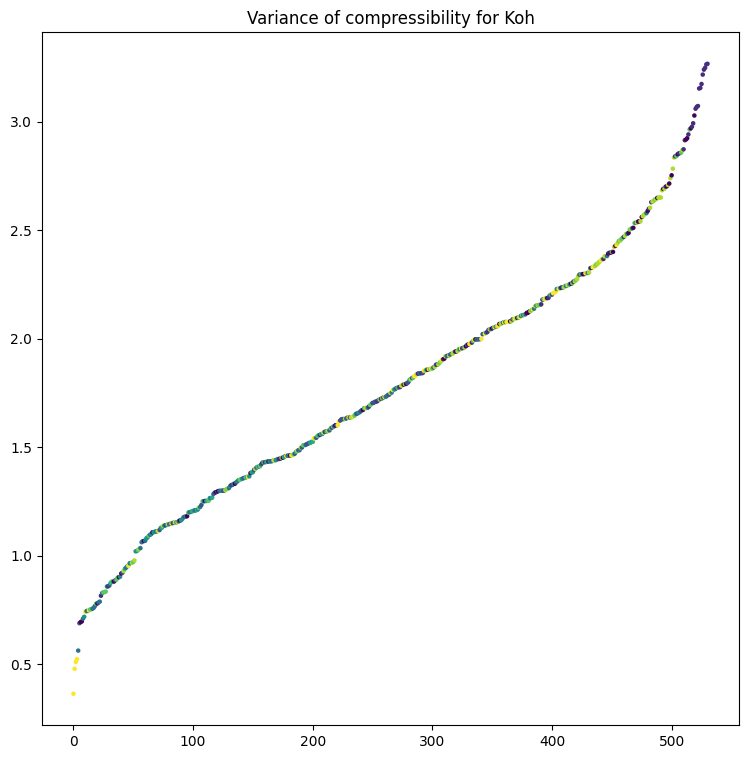

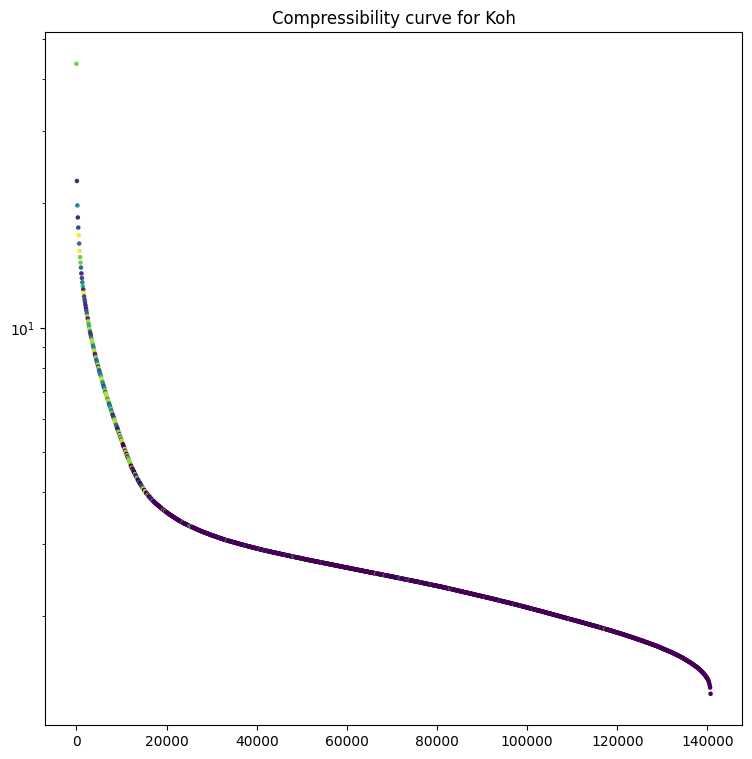

100%|██████████| 25/25 [01:40<00:00,  4.00s/it]


ARI without removal: 0.8003131966060096
NMI without removal: 0.8590325964618907
Avg intercluster compressibility [2.01377177 1.90416891 1.51138838]
Avg intracluster compressibility [10.94613845  8.73087696 10.34747881]


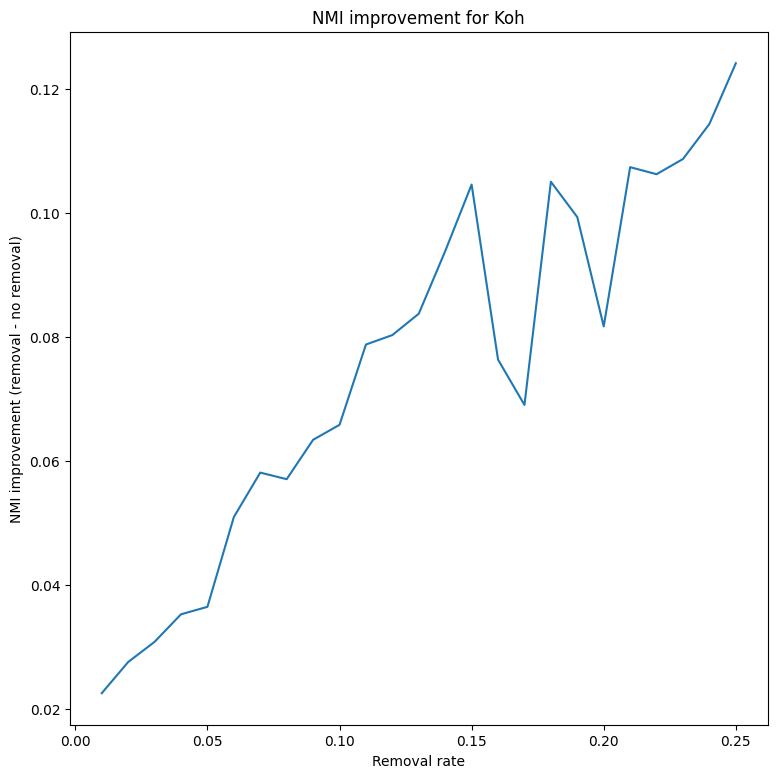

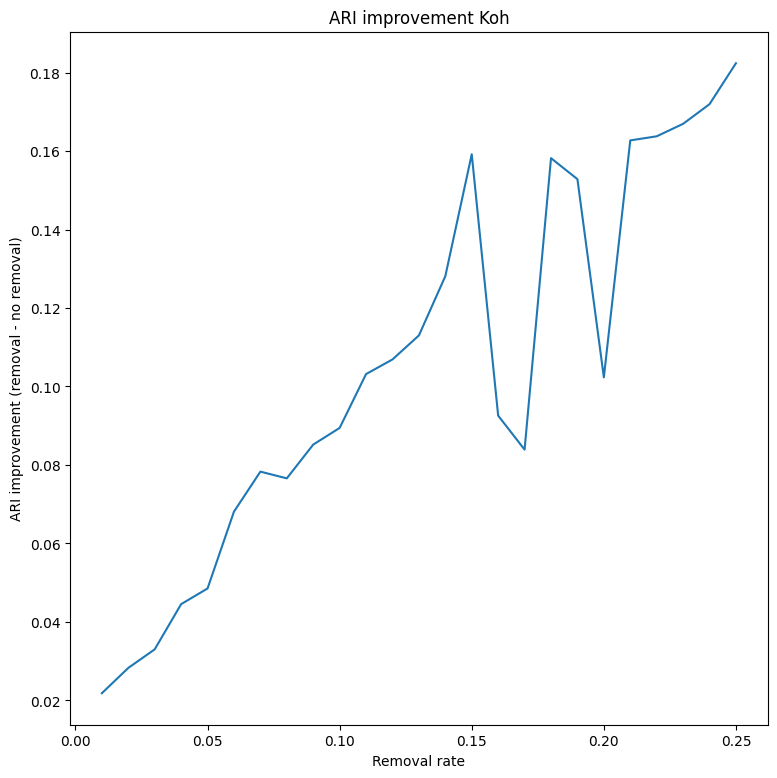

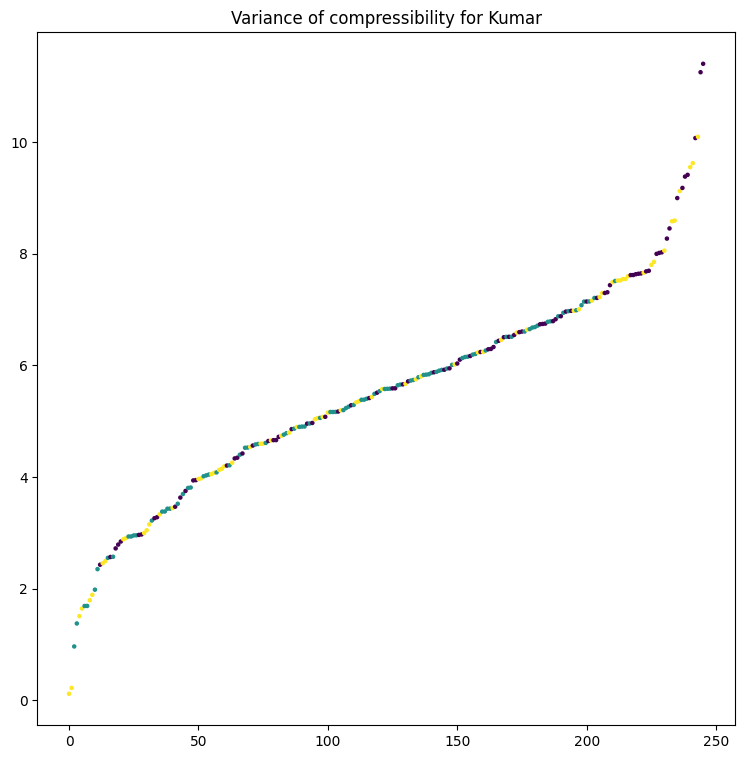

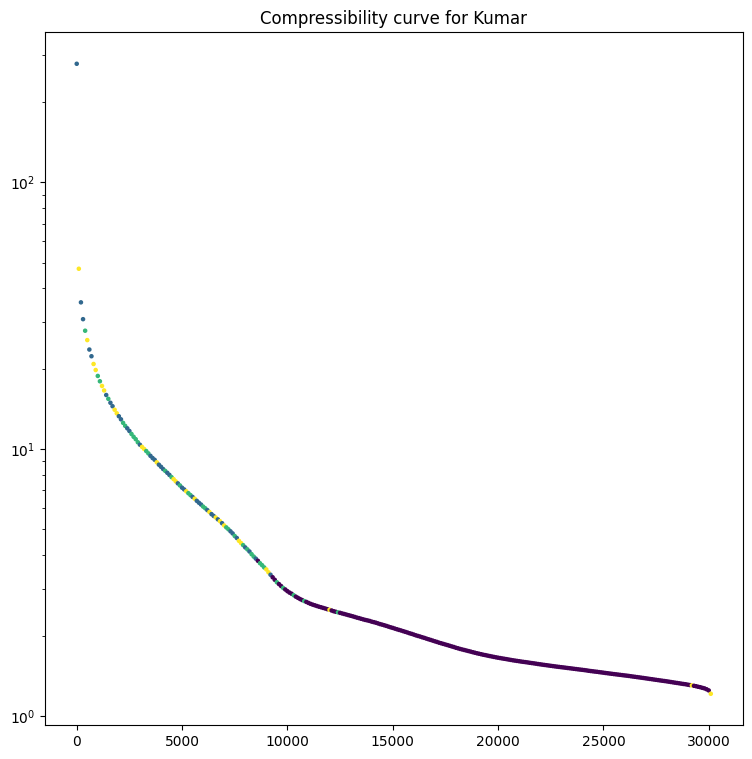

100%|██████████| 25/25 [01:11<00:00,  2.84s/it]


ARI without removal: 0.9507837448896125
NMI without removal: 0.923781516234857
Avg intercluster compressibility [3.39586881 3.30853591 3.07730335 2.80946014]
Avg intracluster compressibility [14.10063809 14.562657   13.538867   13.23659013]


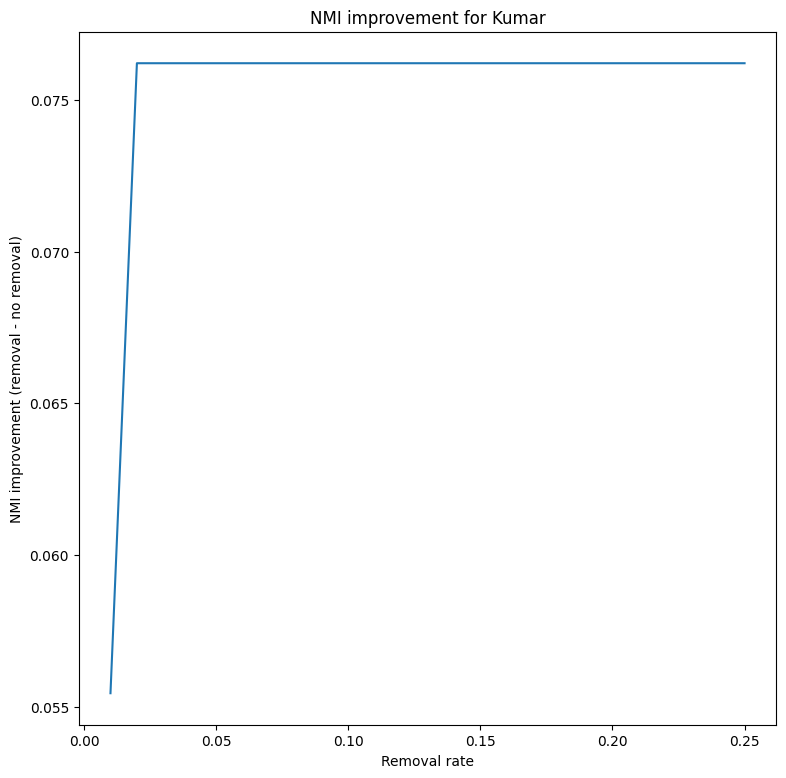

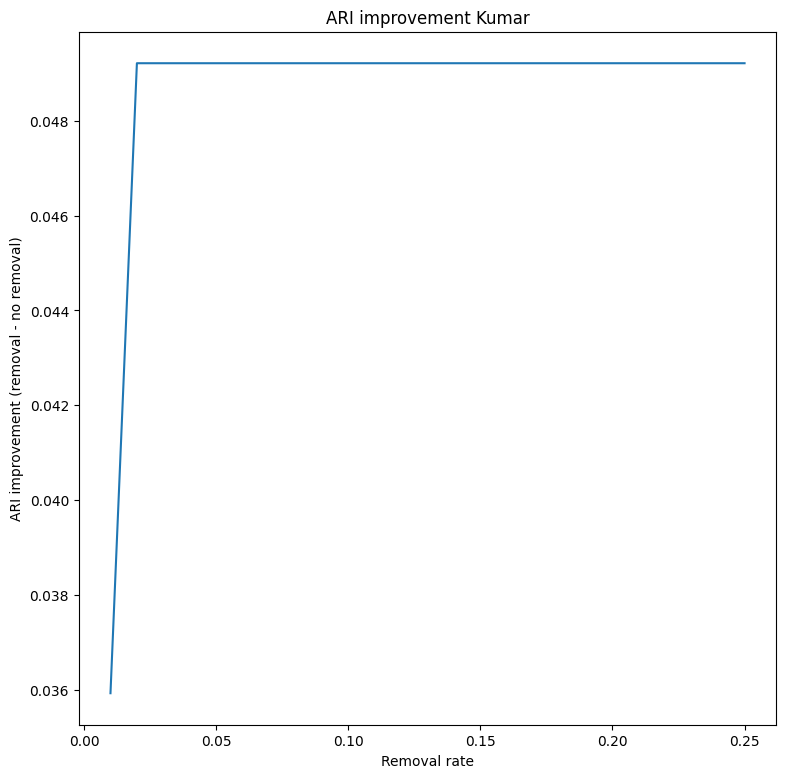

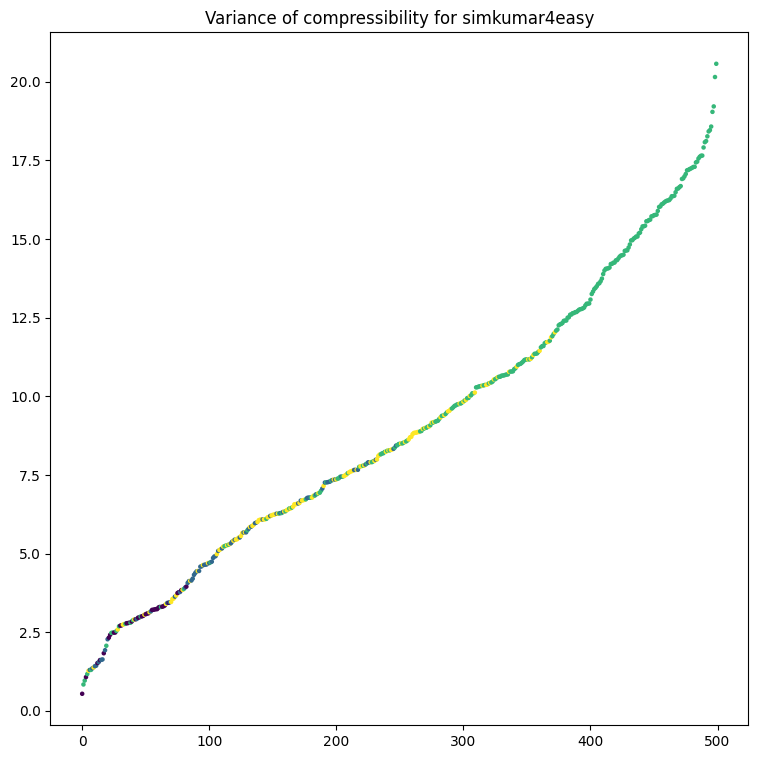

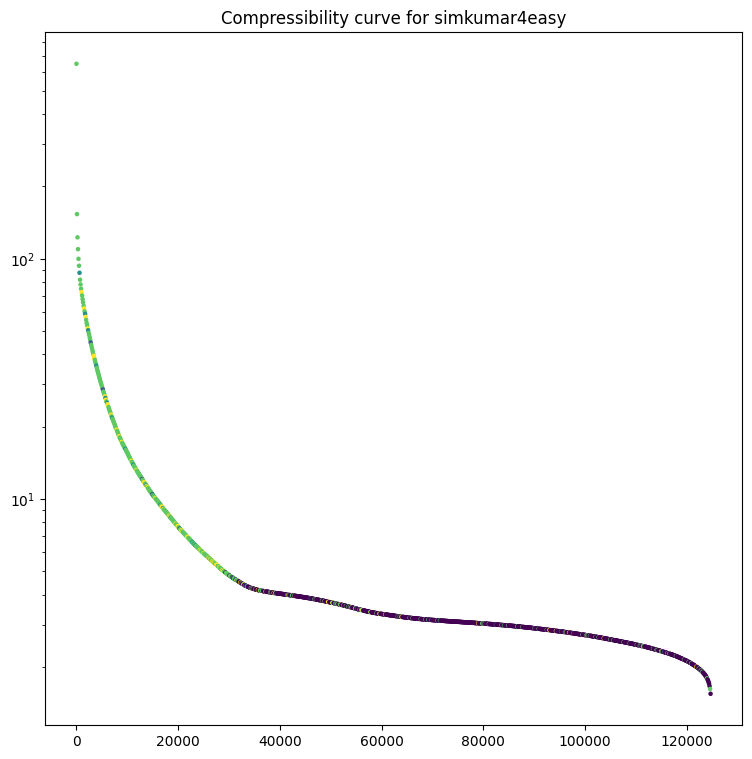

100%|██████████| 25/25 [01:16<00:00,  3.05s/it]


ARI without removal: 0.6269079977614556
NMI without removal: 0.7618201338574817
Avg intercluster compressibility [4.92761441 4.53640422 4.66340437 4.3331462 ]
Avg intracluster compressibility [12.45143797 14.67148155 12.18912956 11.80848025]


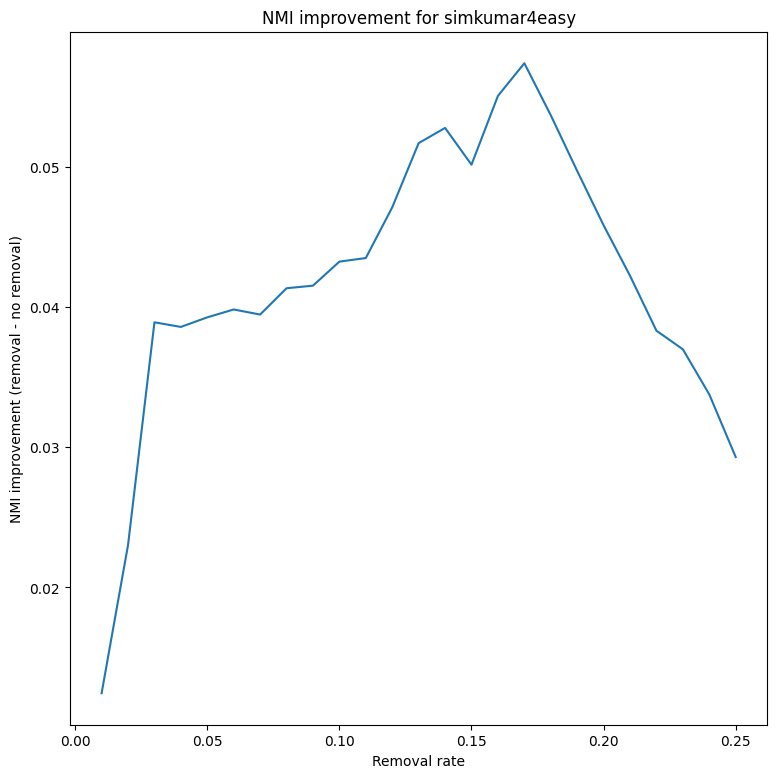

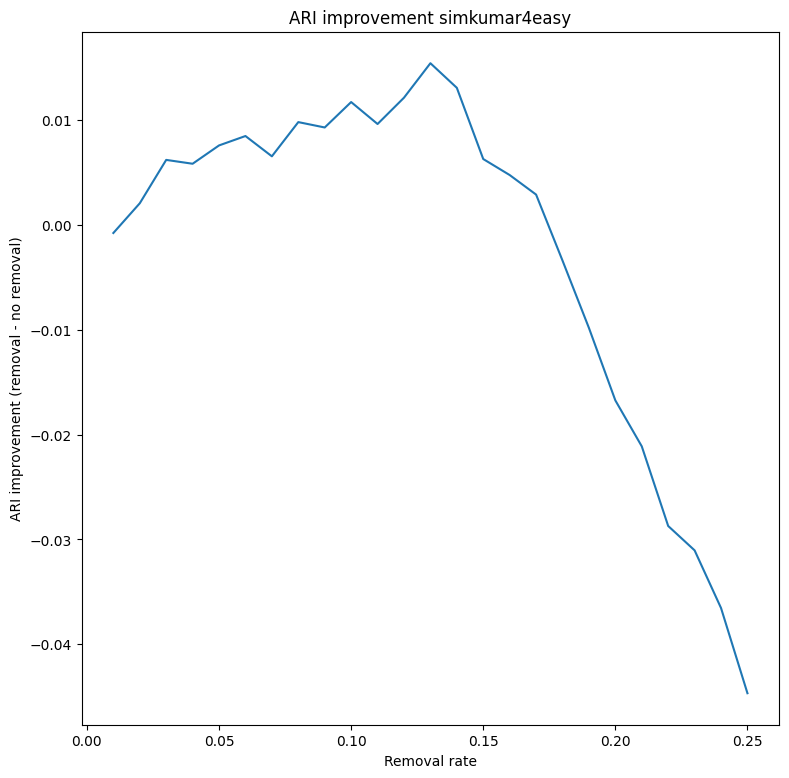

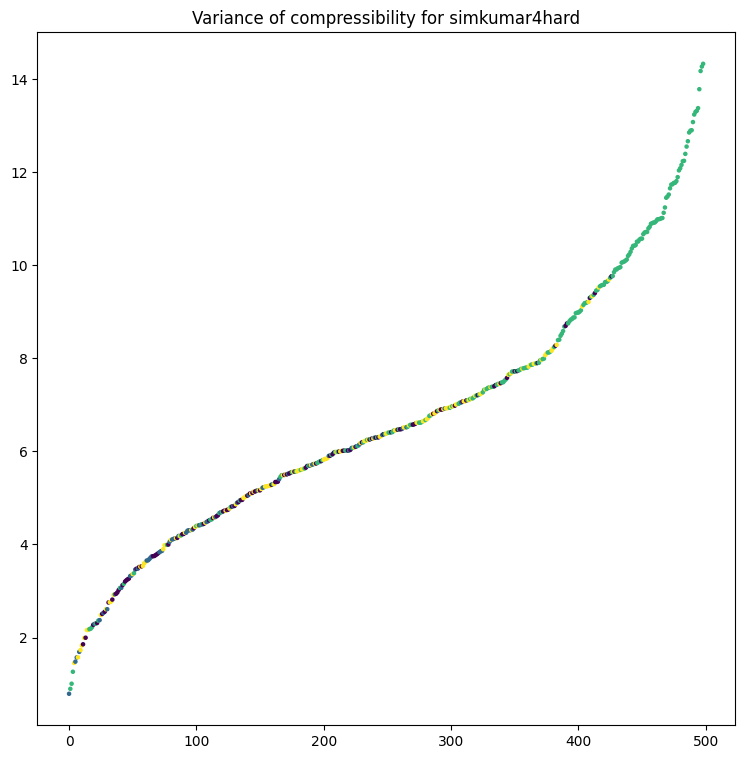

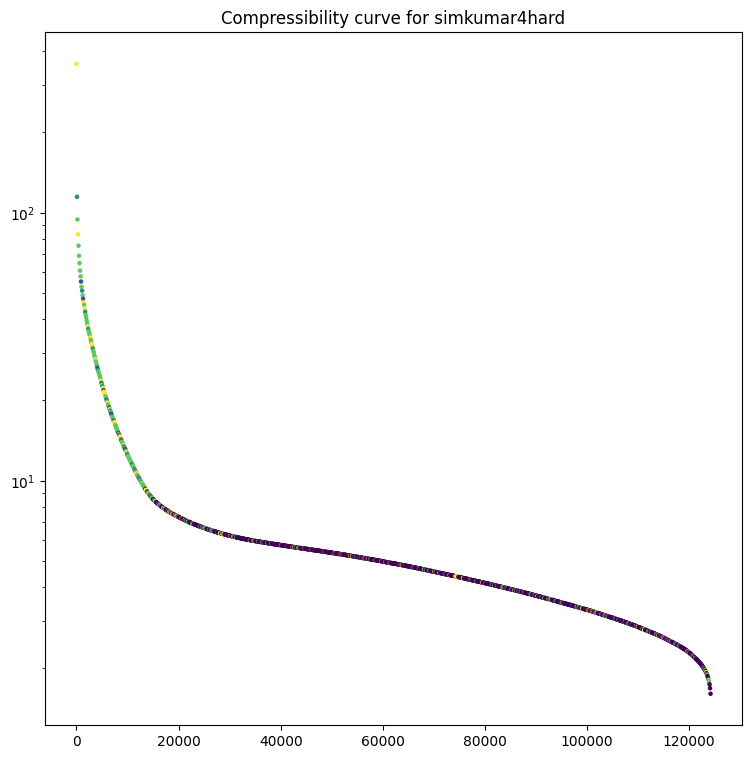

100%|██████████| 25/25 [01:17<00:00,  3.09s/it]


ARI without removal: 0.16482763251632726
NMI without removal: 0.23728892432507084
Avg intercluster compressibility [4.29942027 4.59635387 4.25426557 4.35586506 4.26950275 3.92270792
 3.91938768 3.62179474]
Avg intracluster compressibility [7.84748837 8.9599407  7.66063822 7.72795581 8.1608332  8.1978975
 7.66943222 9.61500116]


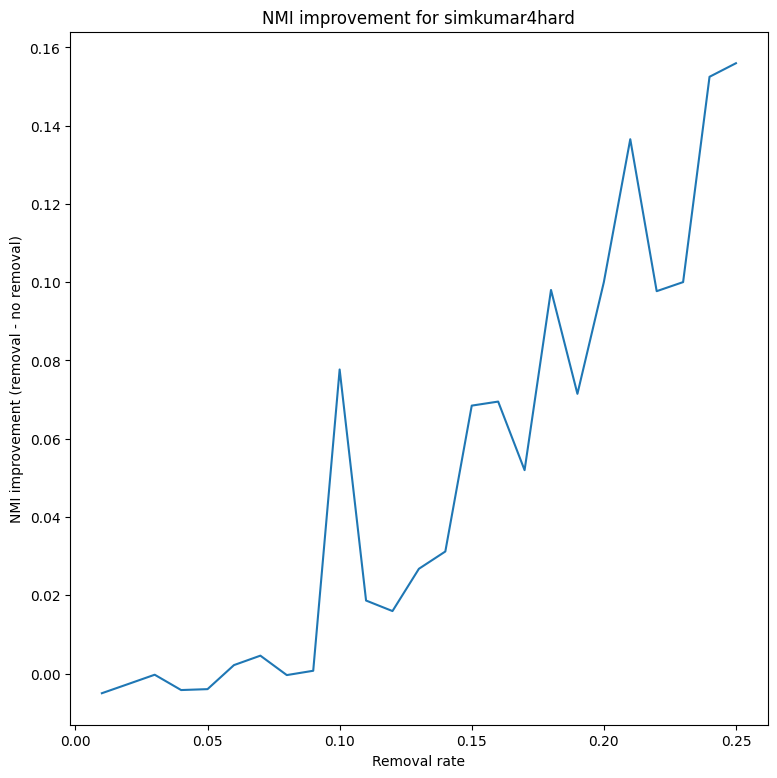

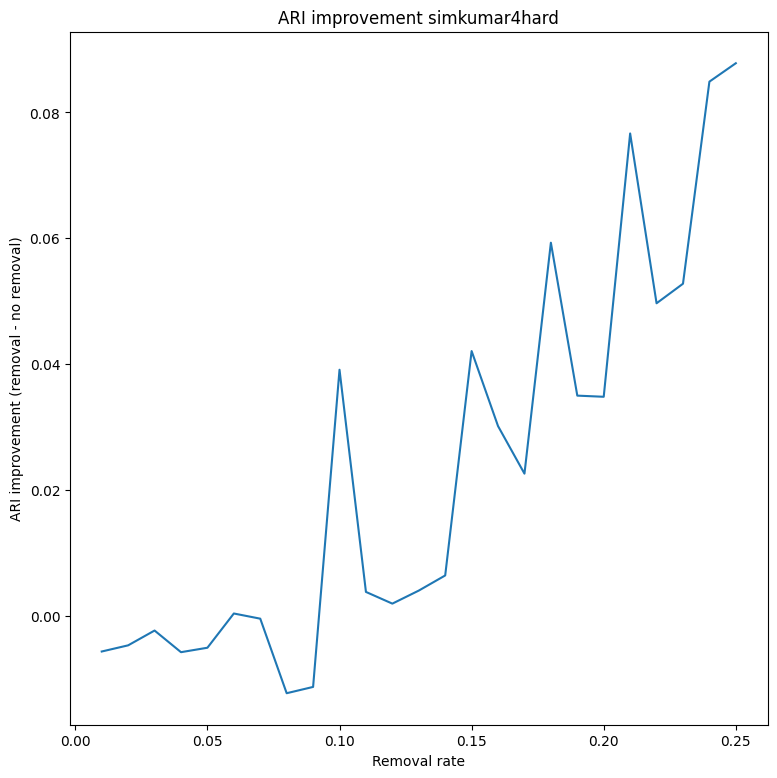

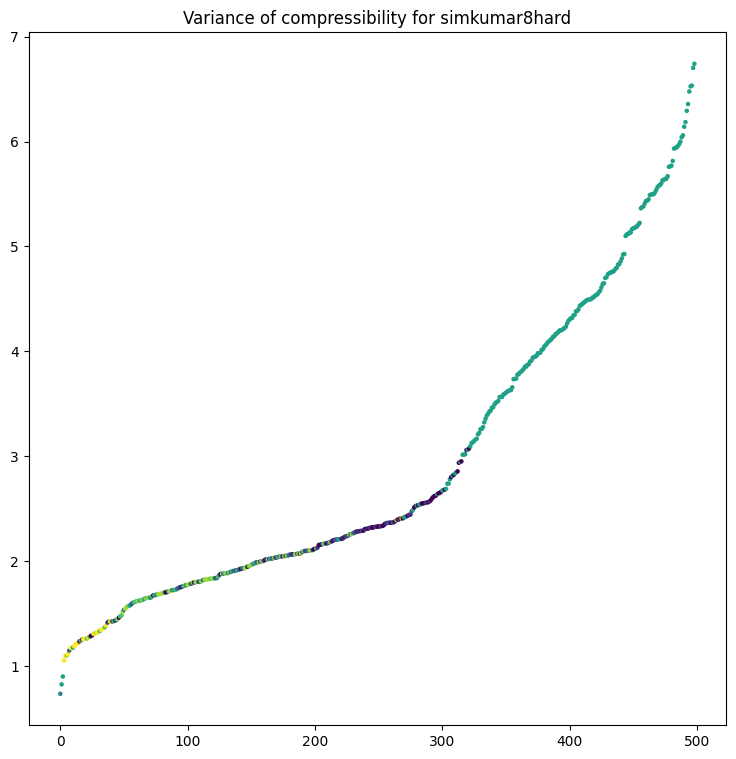

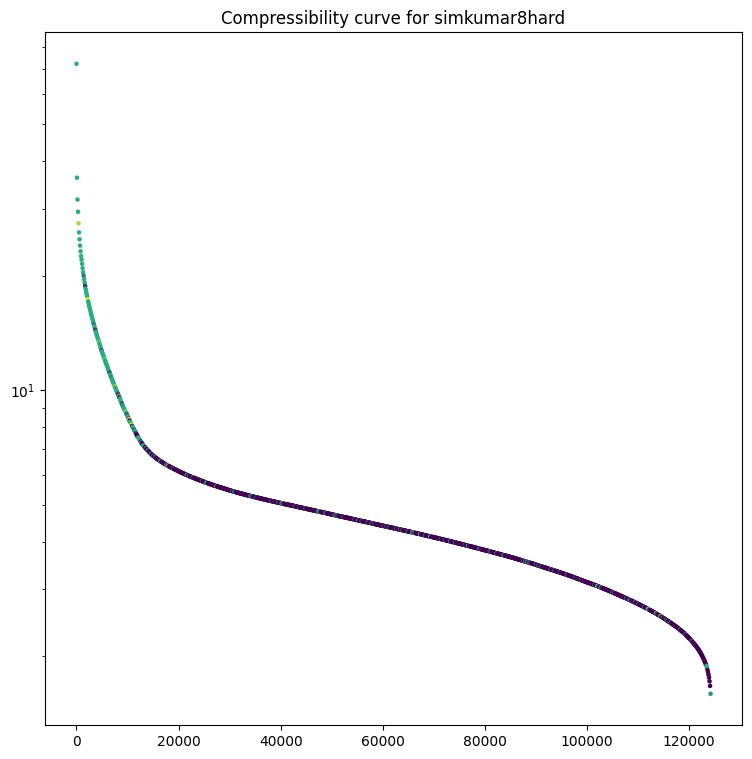

100%|██████████| 25/25 [01:33<00:00,  3.75s/it]


ARI without removal: 0.24845101481826845
NMI without removal: 0.42603245077468954
Avg intercluster compressibility [3.60364781 4.82261131 4.69148433]
Avg intracluster compressibility [5.91345756 6.23246818 6.16450956]


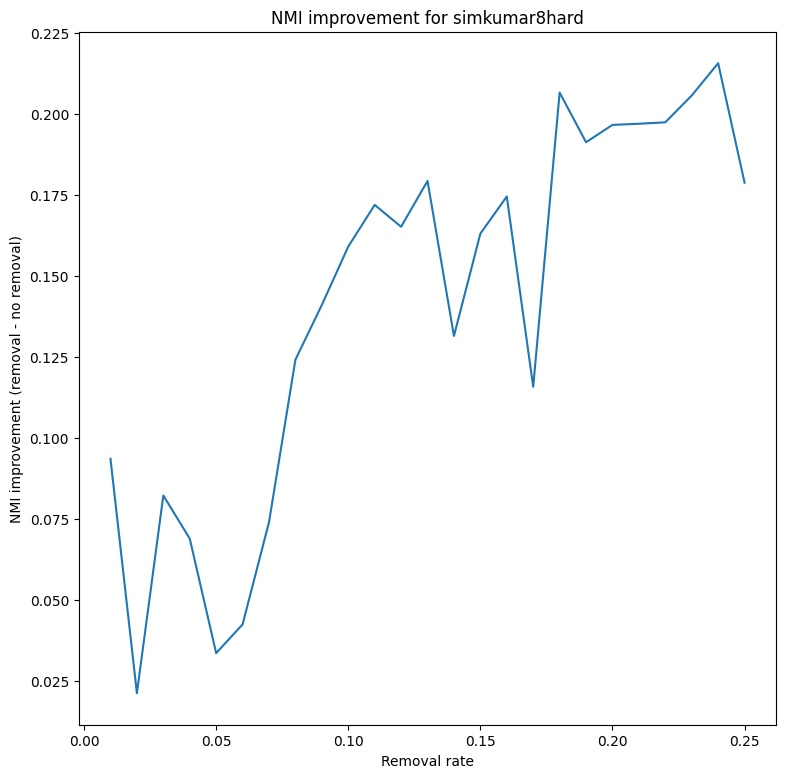

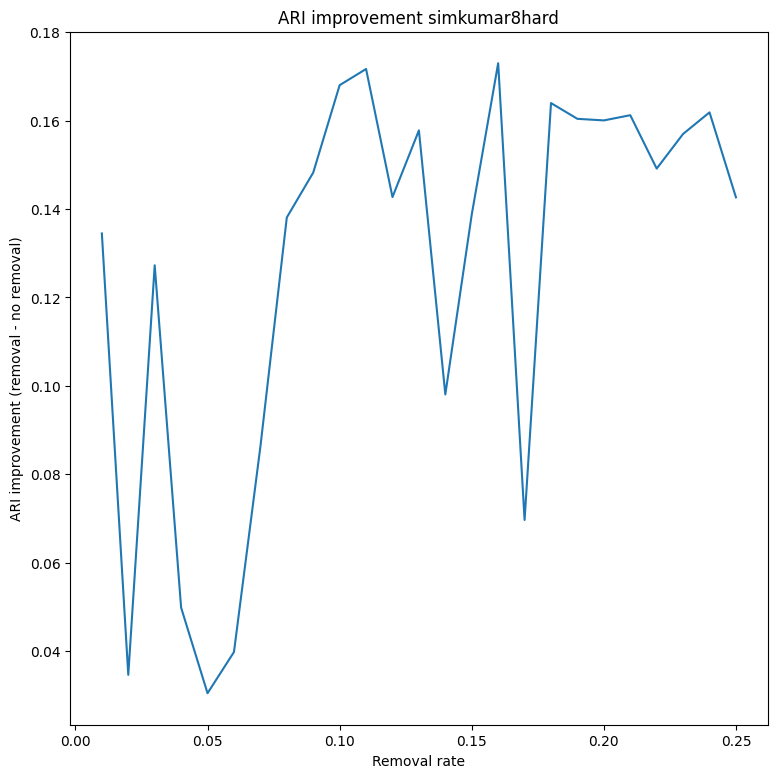

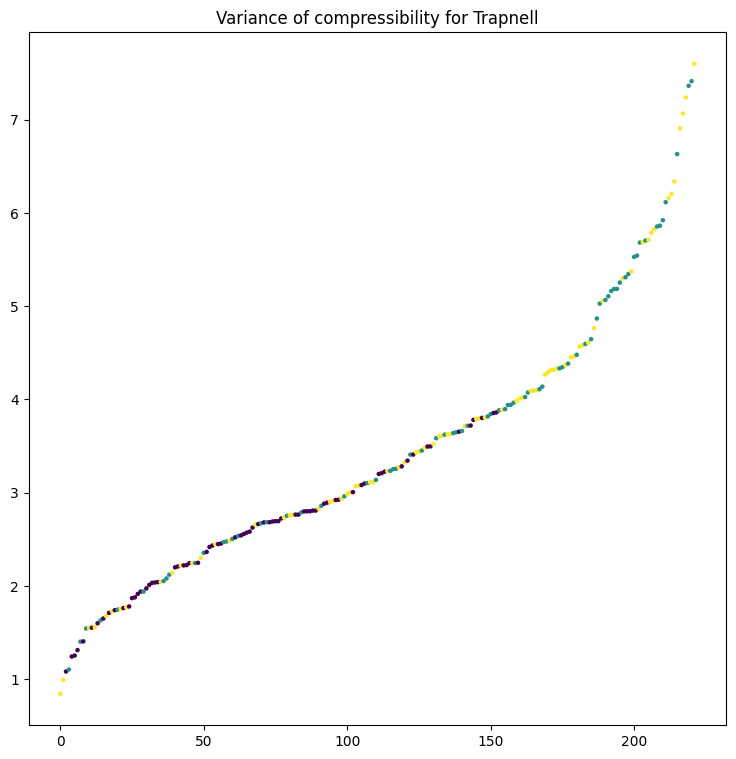

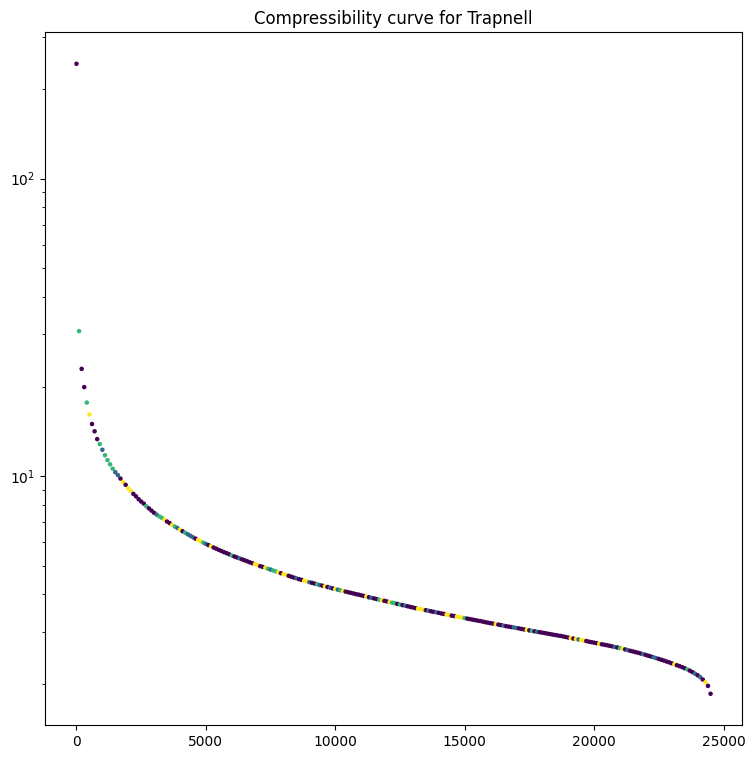

100%|██████████| 25/25 [01:09<00:00,  2.76s/it]


ARI without removal: 0.26736111186426015
NMI without removal: 0.28606645937417113
Avg intercluster compressibility [2.01971456 1.69405043 2.25248836 2.32123145]
Avg intracluster compressibility [5.35631824 5.28801417 6.78049987 5.27209963]


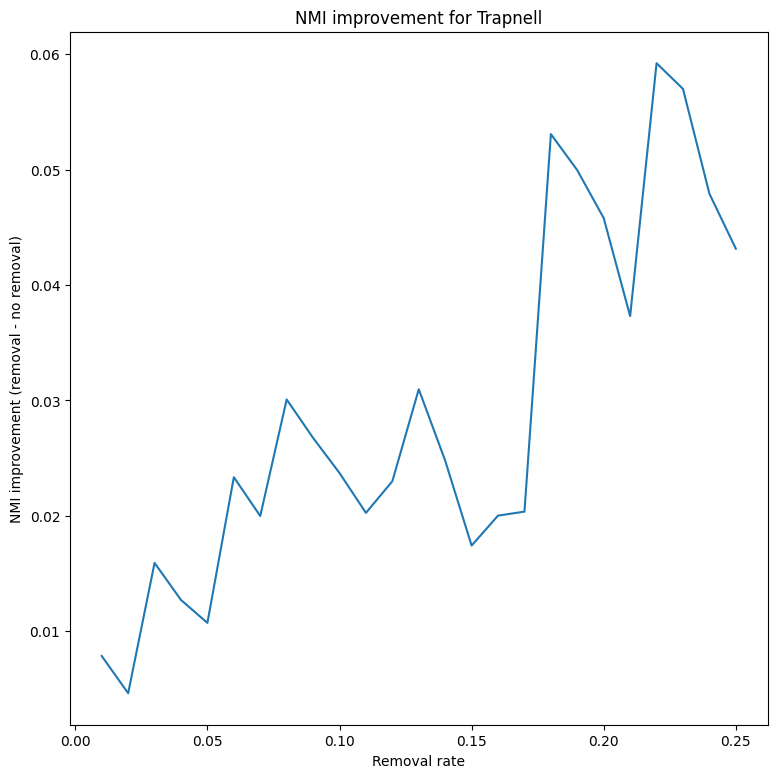

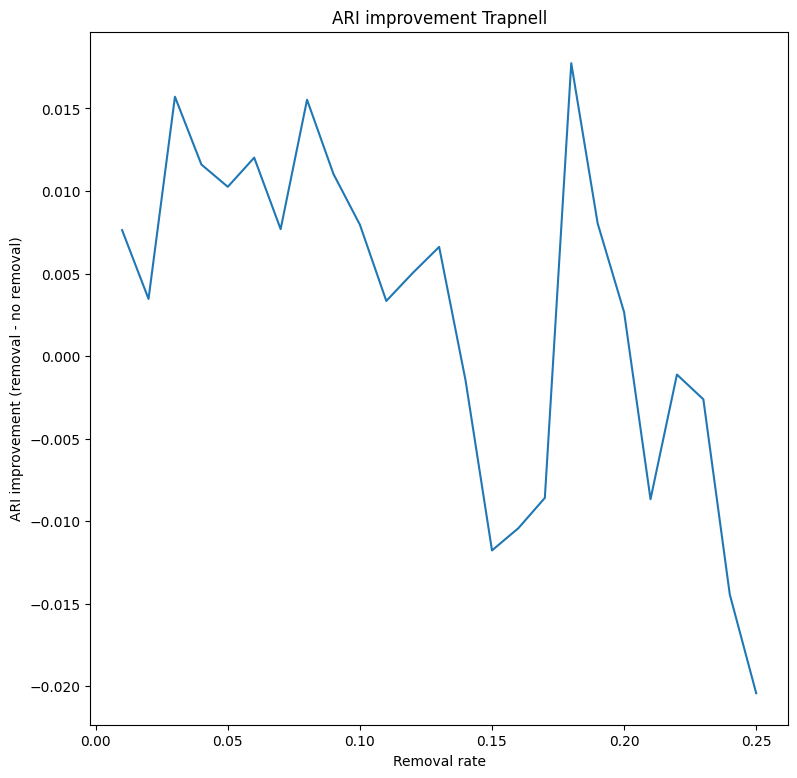

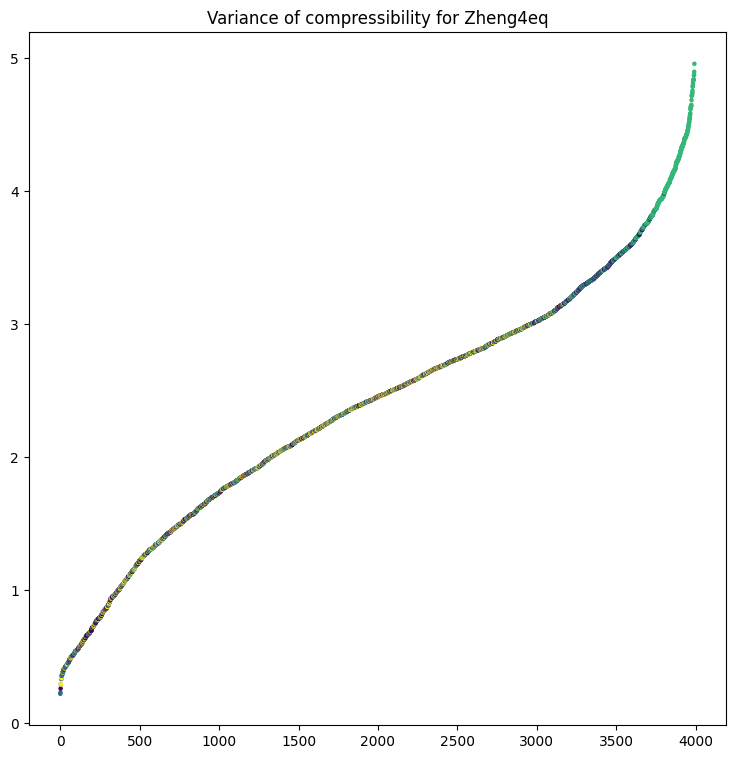

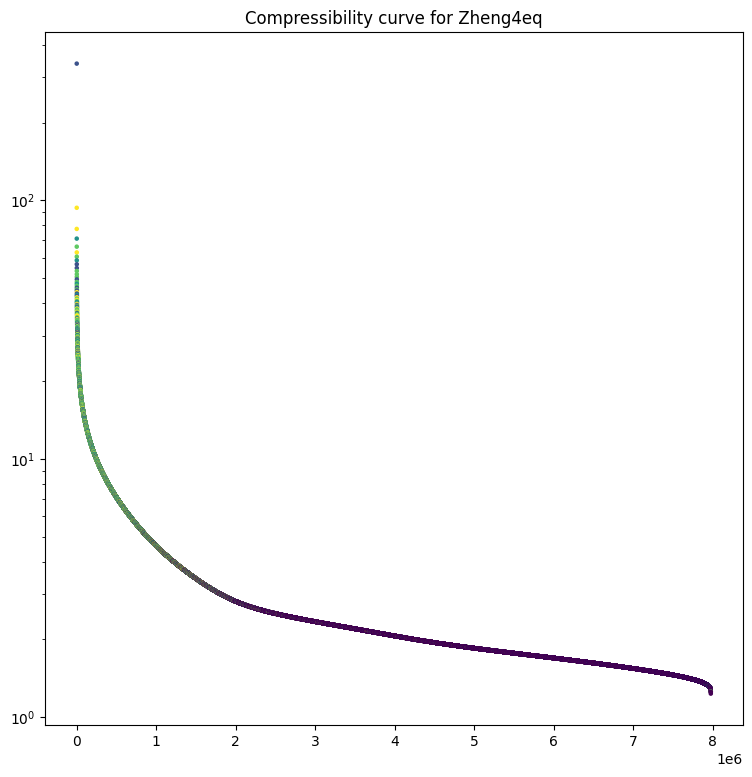

100%|██████████| 25/25 [04:00<00:00,  9.61s/it]


ARI without removal: 0.6287255246783586
NMI without removal: 0.7073847358844679
Avg intercluster compressibility [1.93045148 1.70818449 2.40837    2.02956189]
Avg intracluster compressibility [5.05593631 5.28618187 6.44786619 4.7832041 ]


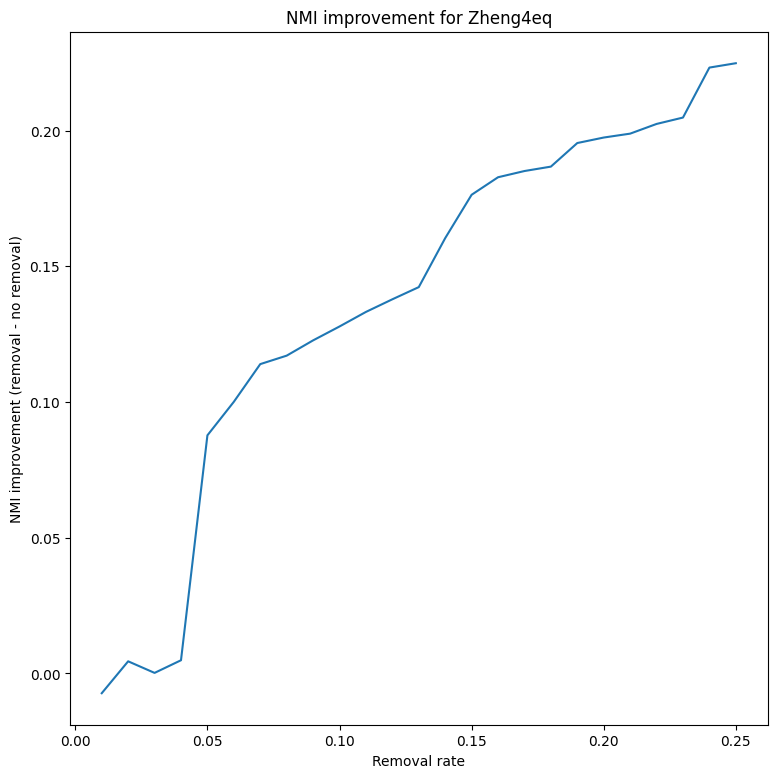

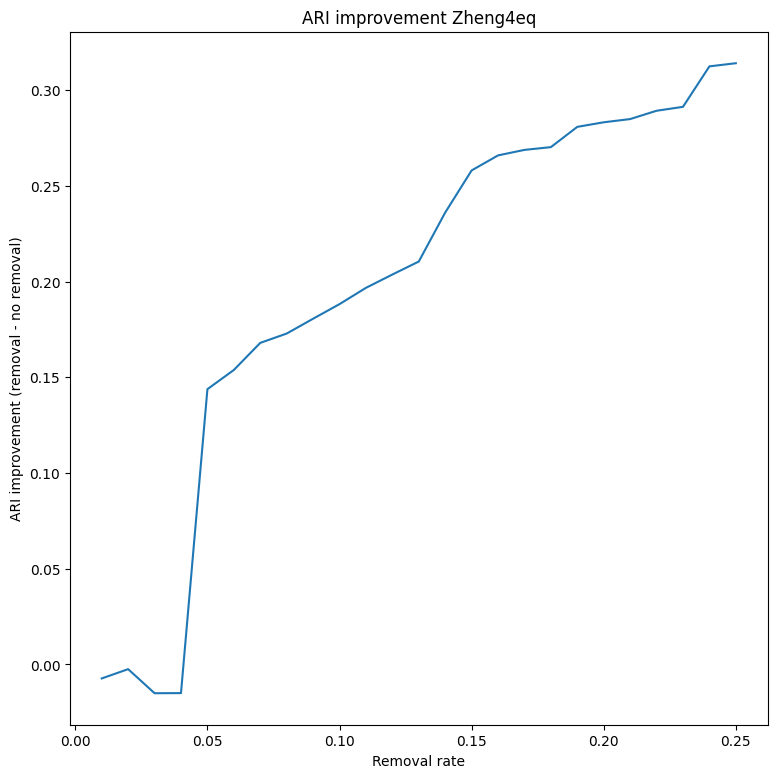

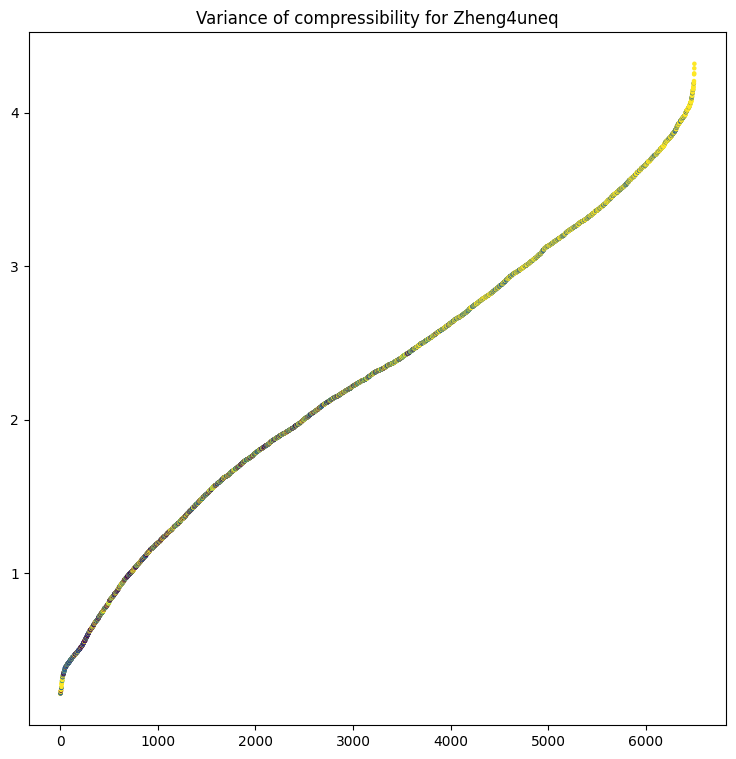

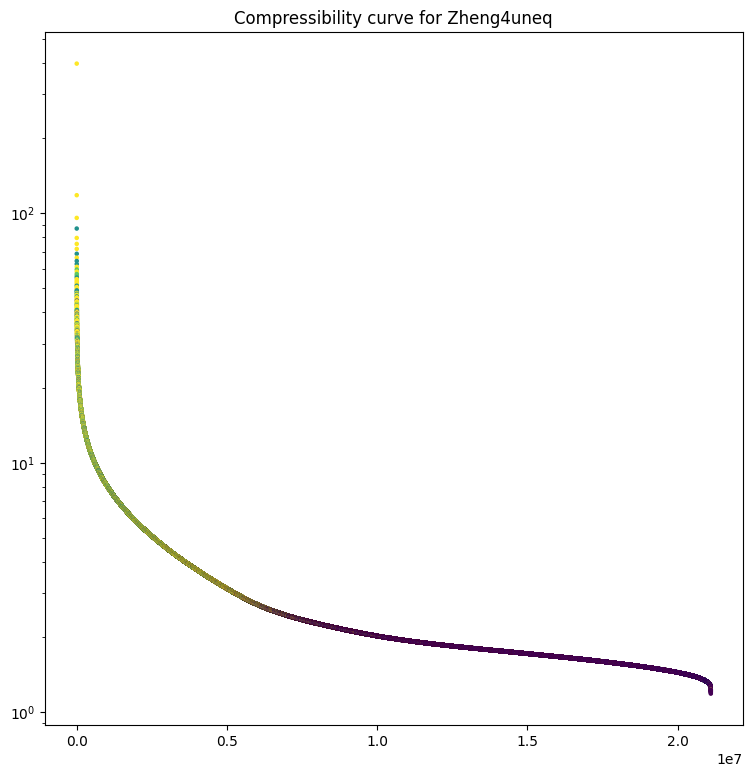

100%|██████████| 25/25 [07:05<00:00, 17.04s/it]


ARI without removal: 0.7380527823082216
NMI without removal: 0.719819096957252
Avg intercluster compressibility [1.96021739 2.78760546 1.64417967 1.92255693 2.50619489 2.53015936
 2.66873355 2.61445438]
Avg intracluster compressibility [3.96475833 4.22662105 4.13530009 4.725289   3.99631929 5.15276942
 4.62019274 3.92472533]


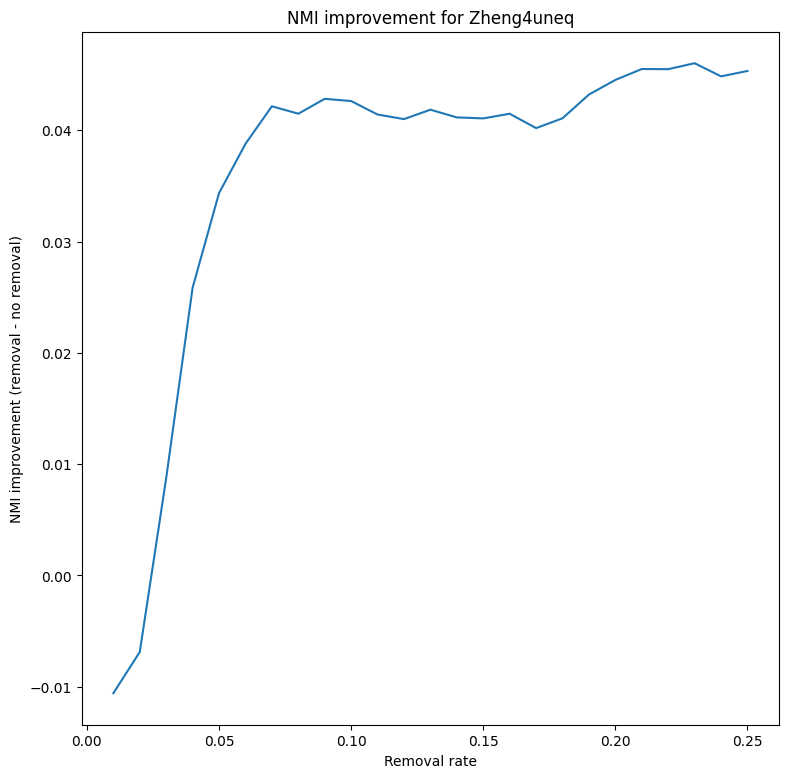

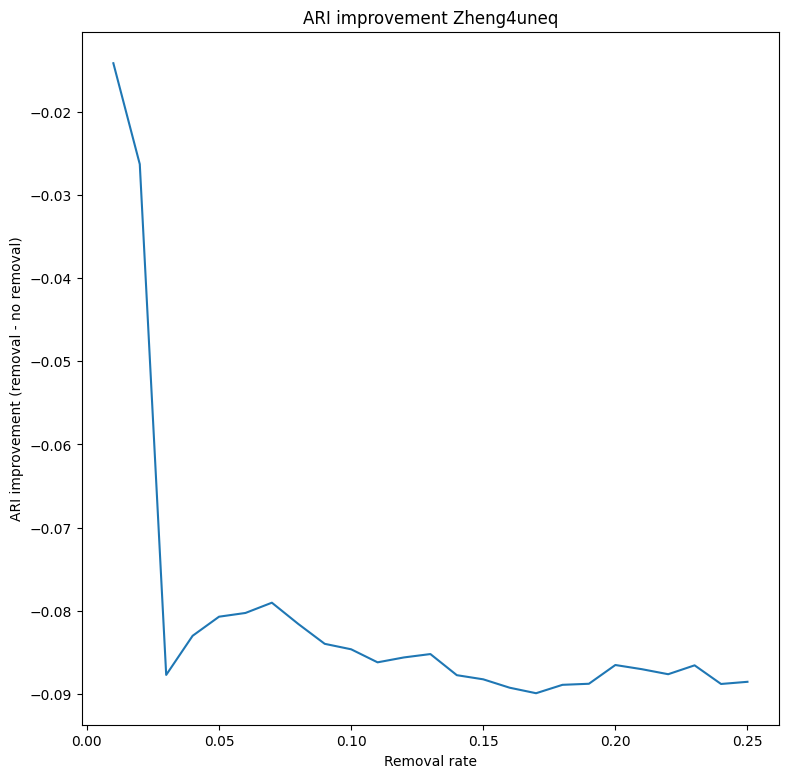

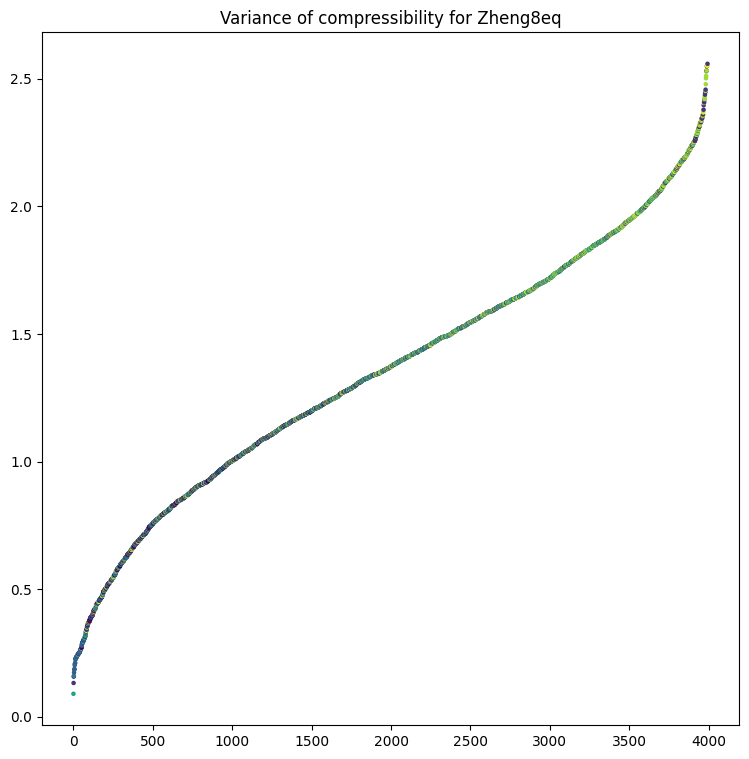

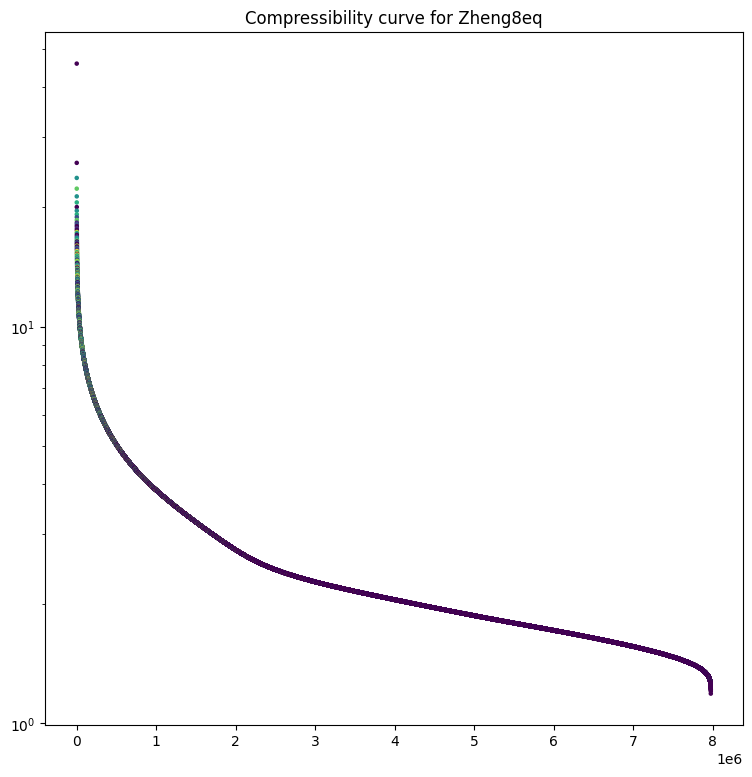

100%|██████████| 25/25 [04:37<00:00, 11.11s/it]


ARI without removal: 0.3859975983504134
NMI without removal: 0.5534739551322696


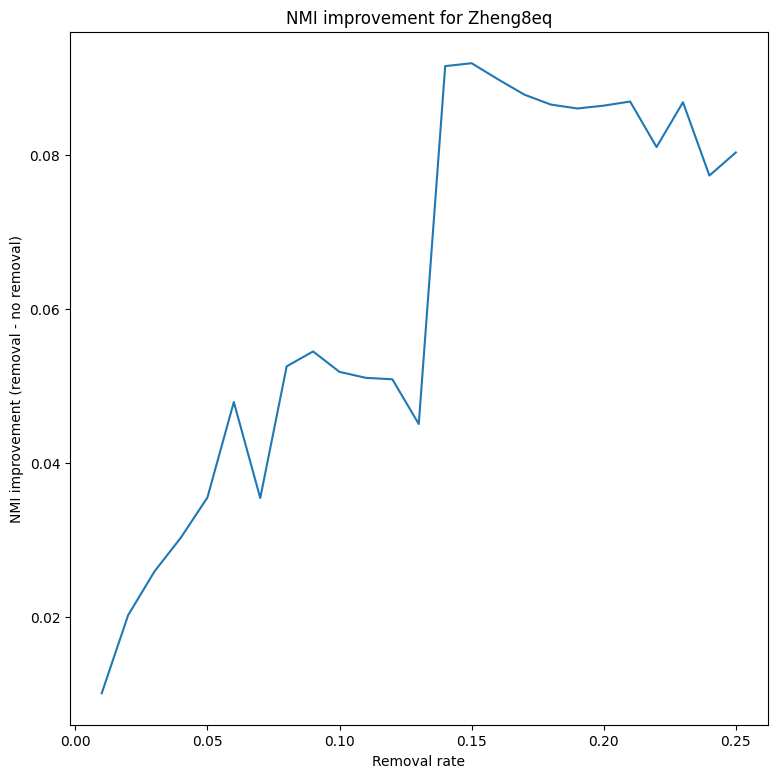

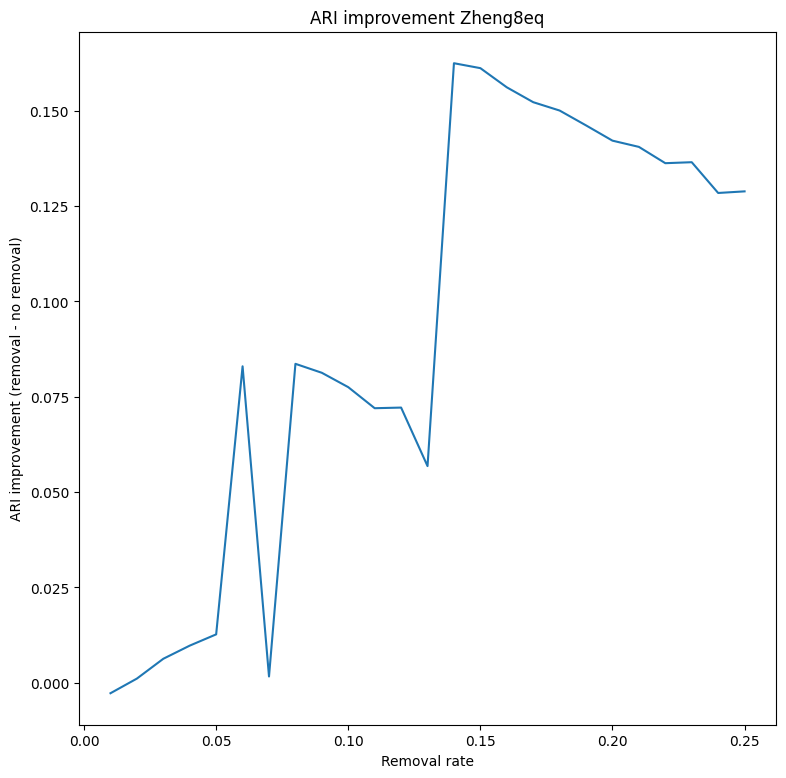

In [14]:
#EXP1
for fix_ch in range(9):
    data, cs, labels = initiate(fix_ch=fix_ch)
    dimension=len(cs)
    C = np.load(dspath[fix_ch][:-5]+'_C_cs.npy')
    process(data,cs,labels,dimension,fix_ch, C)

Avg intercluster compressibility [2.13020215 2.18821844 2.20546764 2.22515674 2.240513   2.24897005
 2.01772537 2.34249446 1.8436378 ]
Avg intracluster compressibility [4.8155104  4.15475407 3.01274893 4.08520576 4.43374062 4.6665418
 3.2128654  5.03865012 4.08724325]


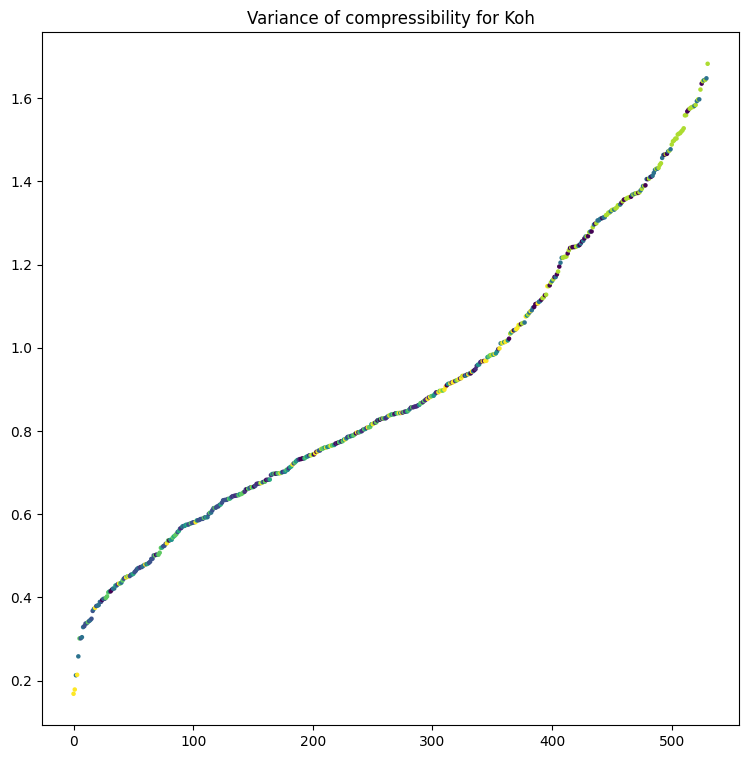

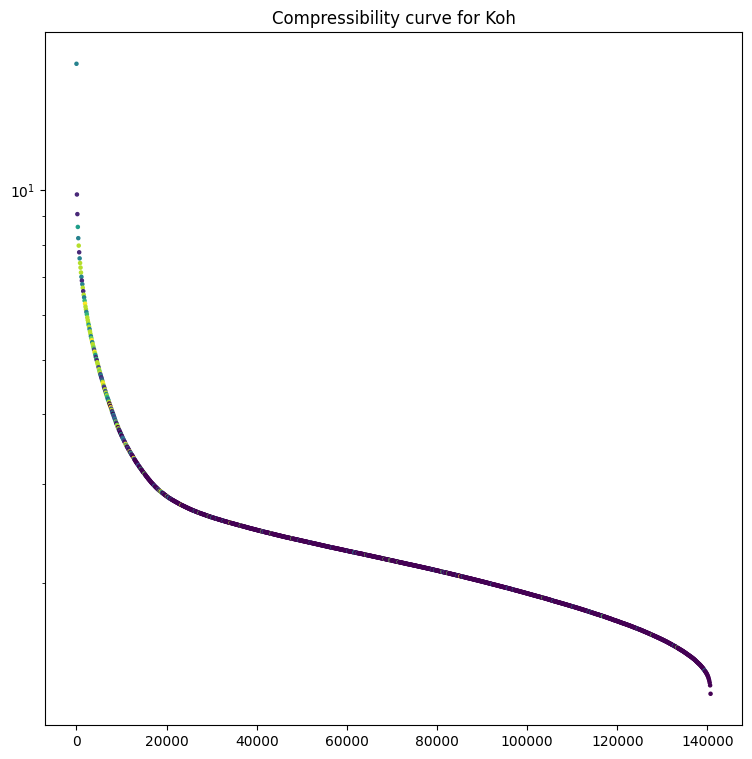

100%|██████████| 25/25 [03:39<00:00,  8.77s/it]


ARI without removal: 0.7954215248222015
NMI without removal: 0.8650527832417416
Avg intercluster compressibility [1.69019342 1.63328254 1.37639011]
Avg intracluster compressibility [2.66404585 3.97615178 2.72085127]


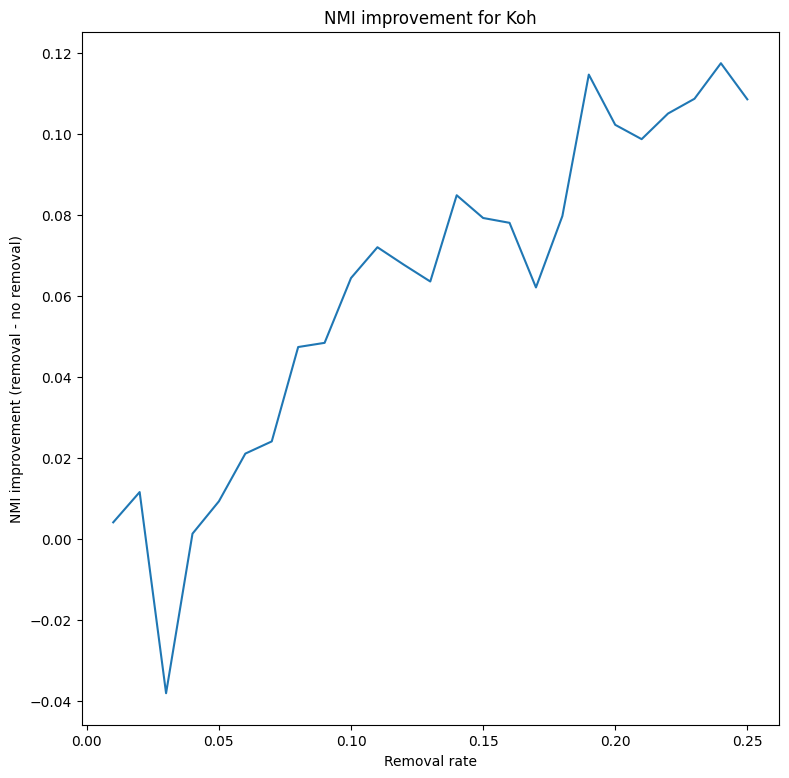

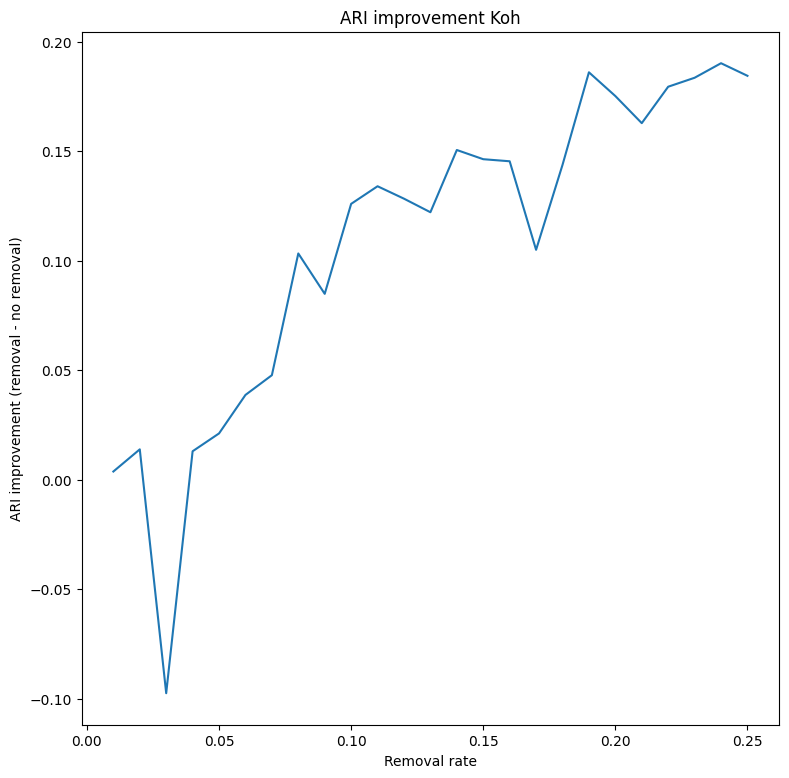

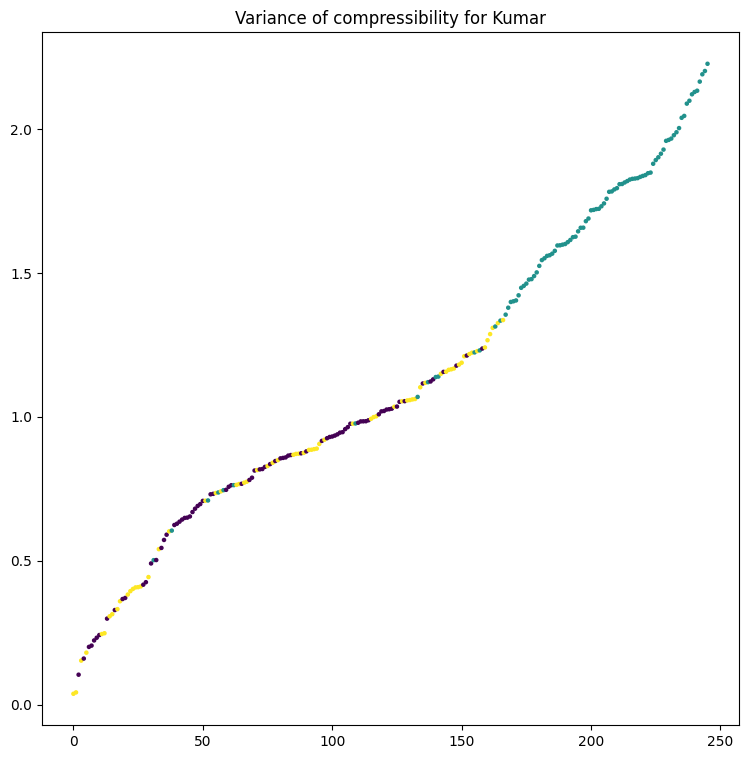

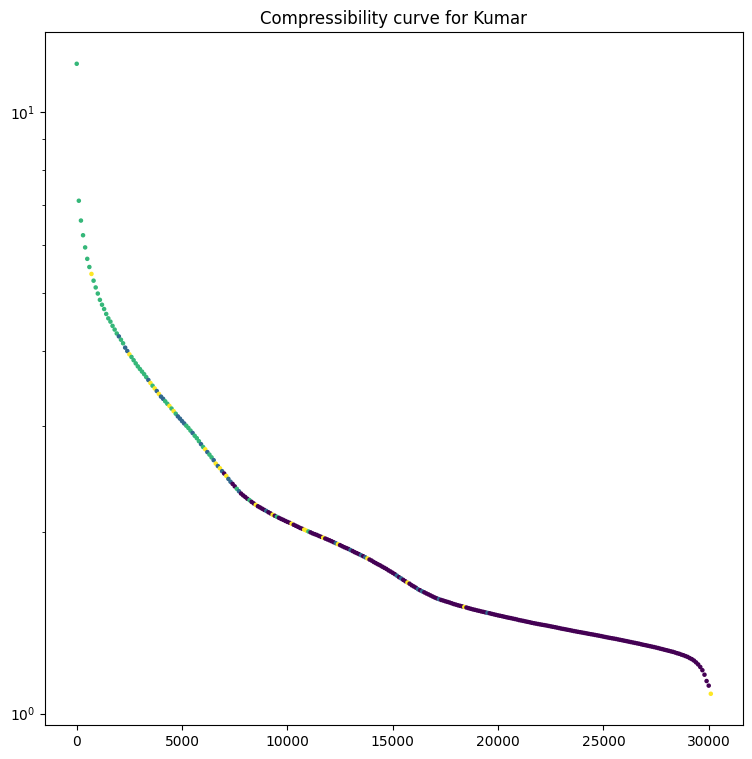

100%|██████████| 25/25 [01:06<00:00,  2.65s/it]


ARI without removal: 0.9637268233080815
NMI without removal: 0.9391626733184053
Avg intercluster compressibility [2.71462916 2.68701199 2.55651183 2.4128227 ]
Avg intracluster compressibility [3.71969693 3.80803077 3.66642758 3.60209201]


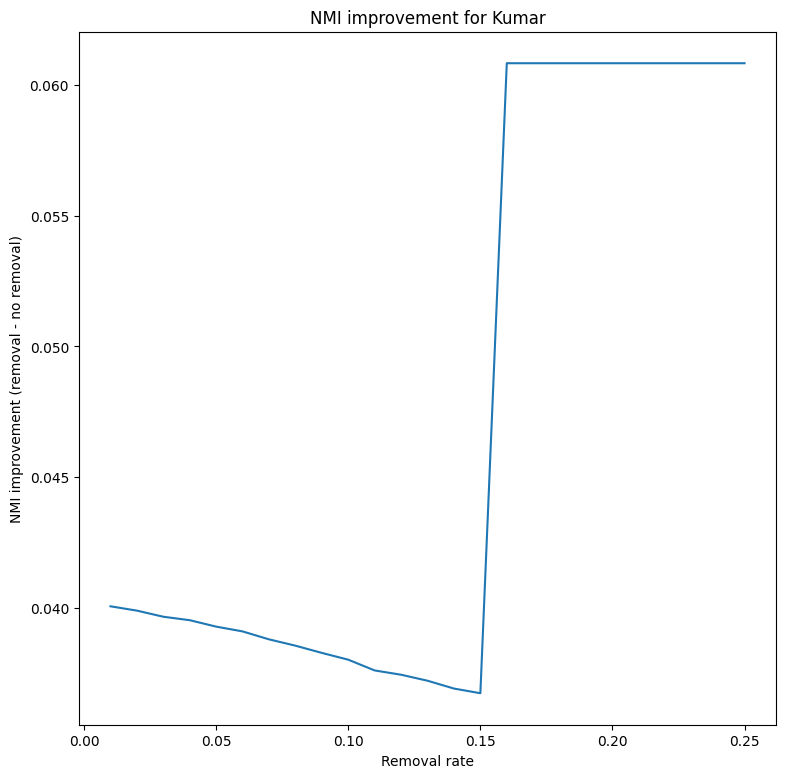

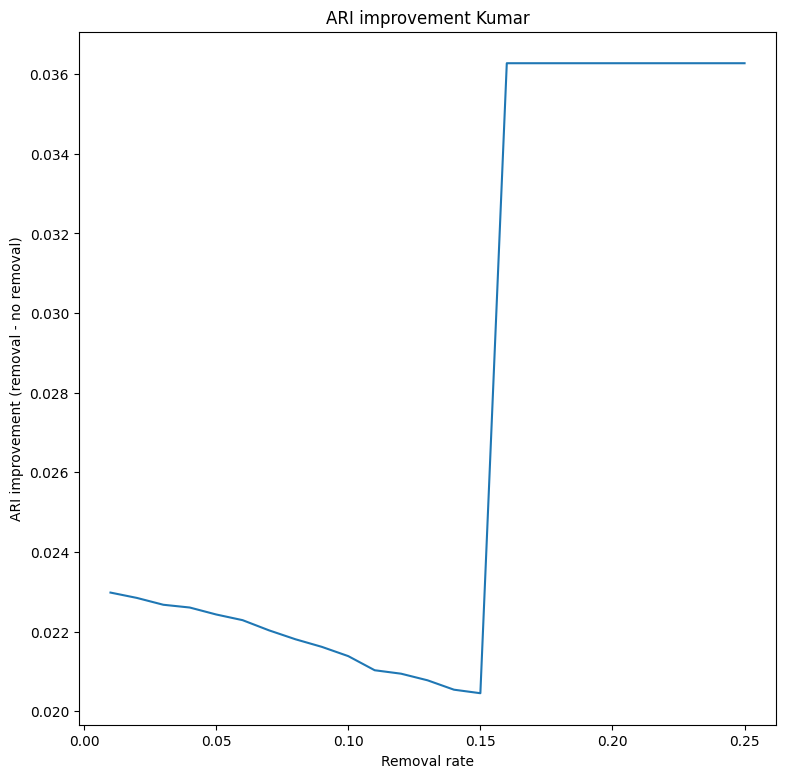

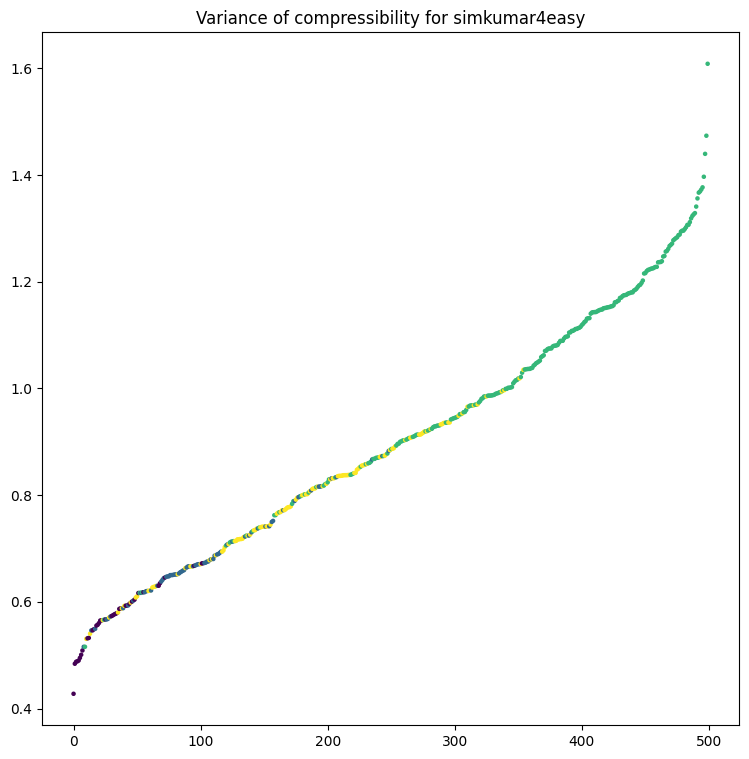

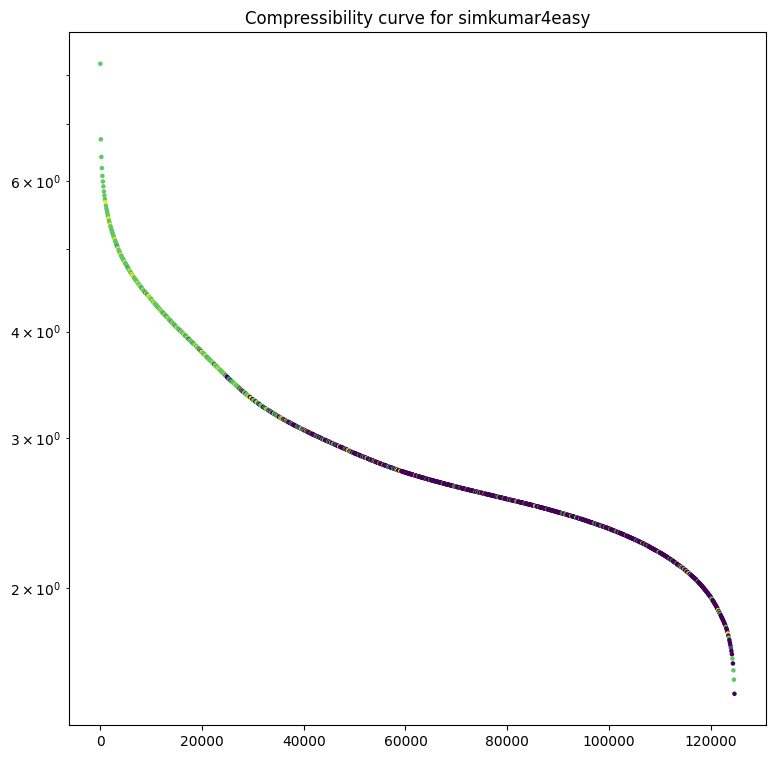

100%|██████████| 25/25 [03:09<00:00,  7.59s/it]


ARI without removal: 0.625366057481096
NMI without removal: 0.7442443975455176
Avg intercluster compressibility [3.25797209 3.14983571 3.17522381 3.0747213 ]
Avg intracluster compressibility [3.75439326 3.77318037 3.66505257 3.55901767]


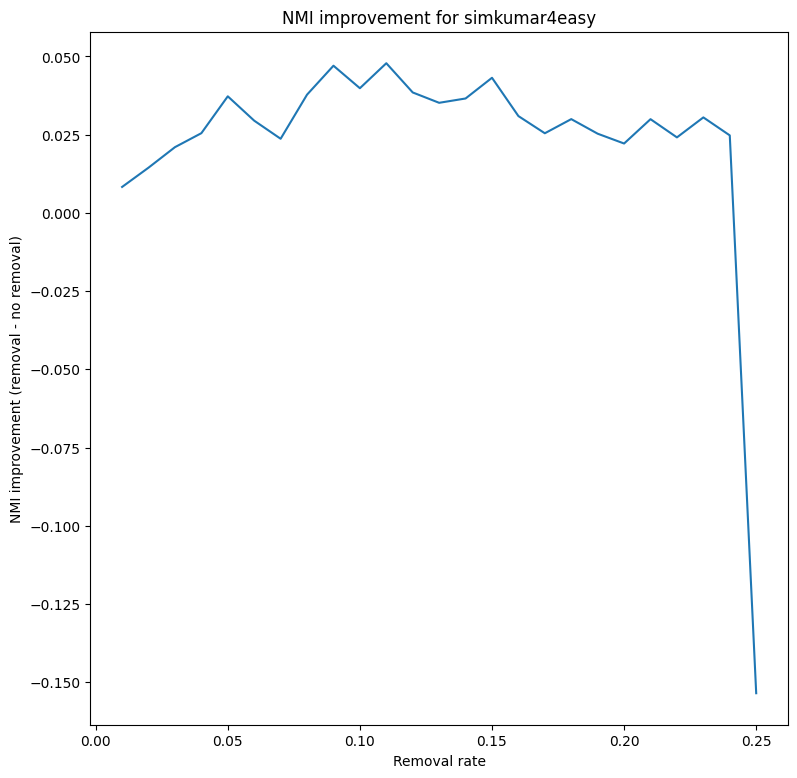

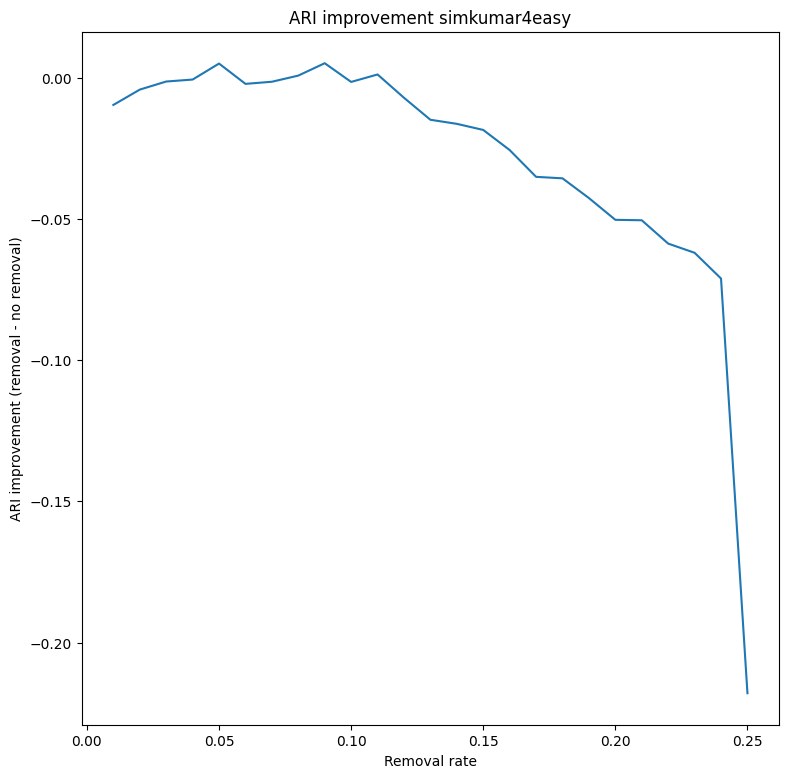

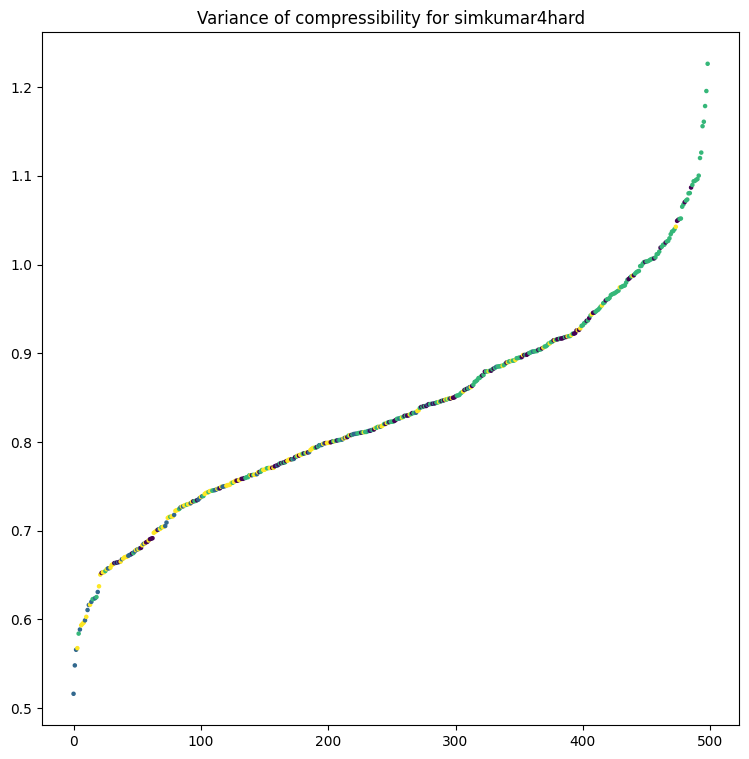

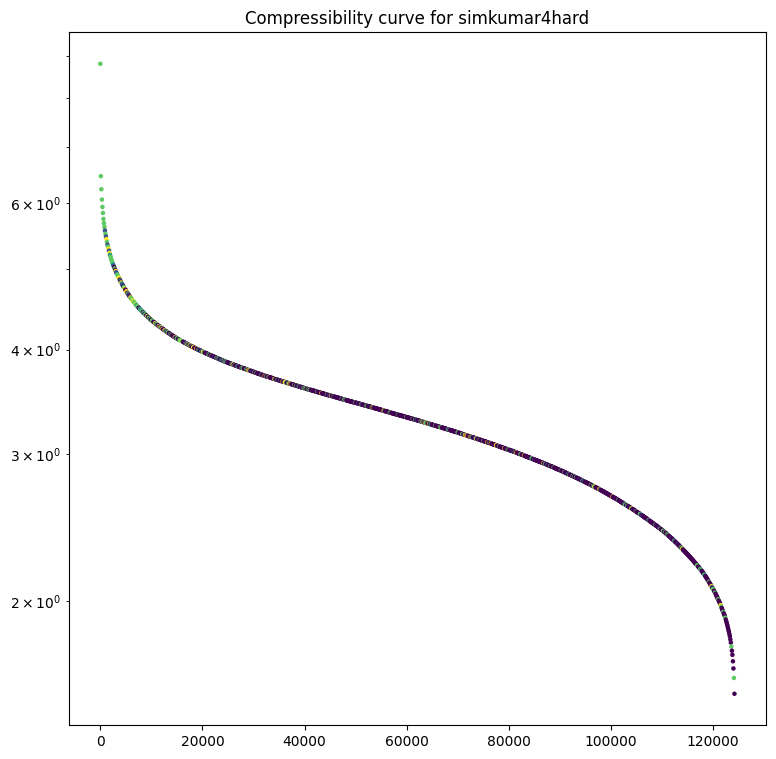

100%|██████████| 25/25 [03:28<00:00,  8.34s/it]


ARI without removal: 0.1608098294613618
NMI without removal: 0.2342230507689816
Avg intercluster compressibility [3.18879302 3.2756918  3.18005945 3.02289582 3.1971303  3.08154926
 3.0653684  2.93448008]
Avg intracluster compressibility [3.72009847 4.18801976 3.8475713  3.68605682 3.88111871 3.97976941
 3.81280491 4.13052292]


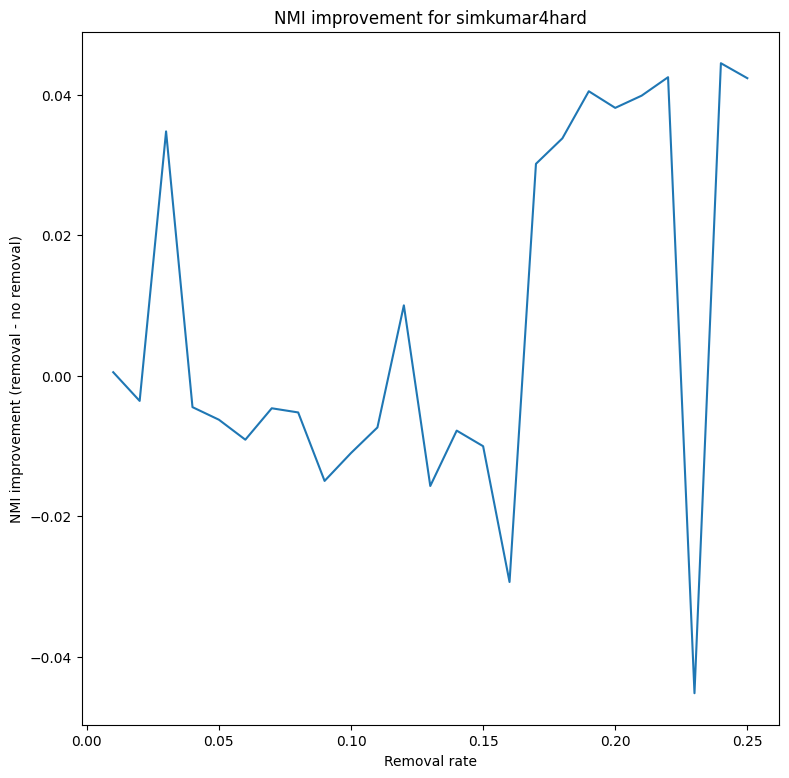

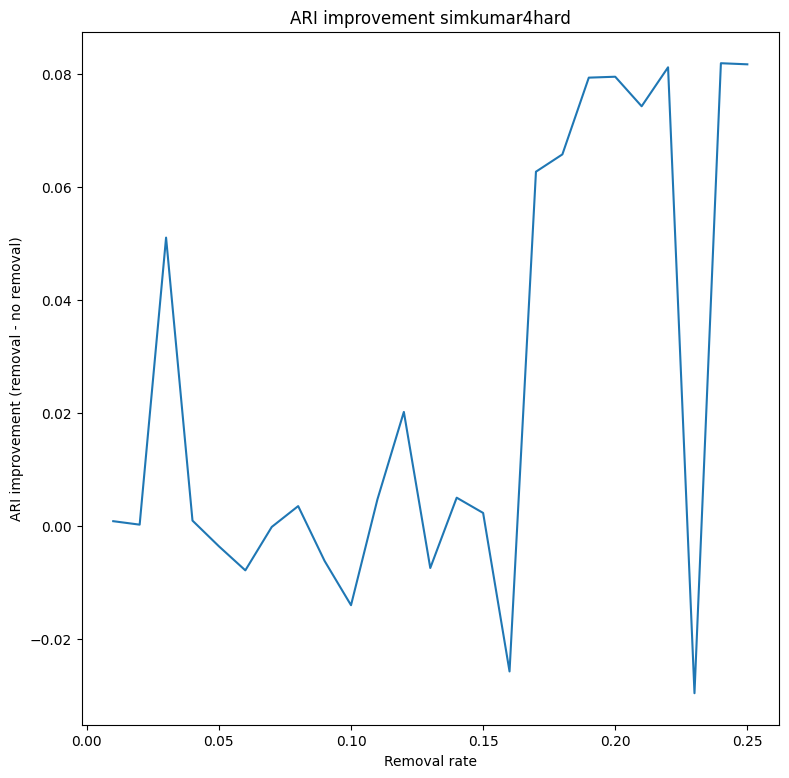

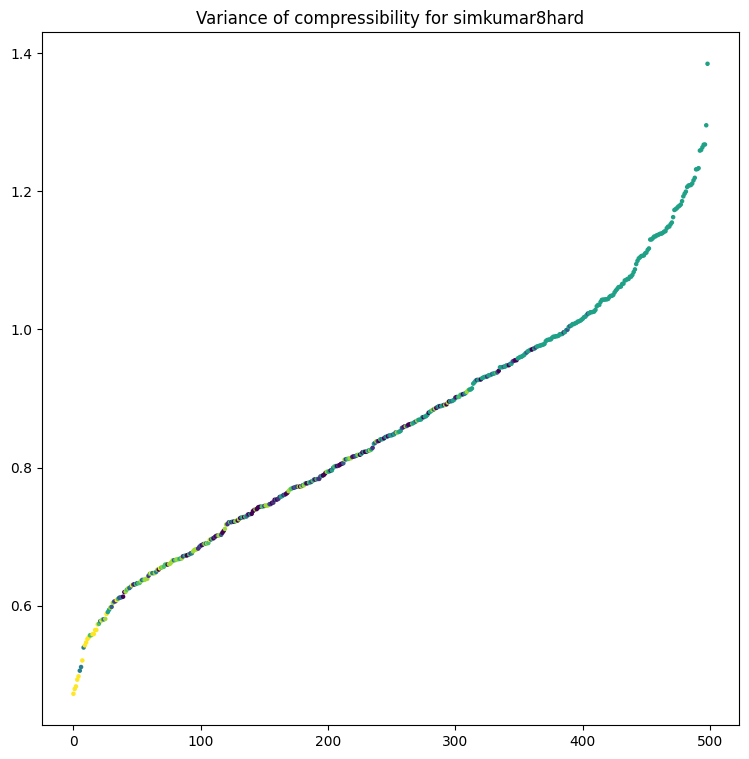

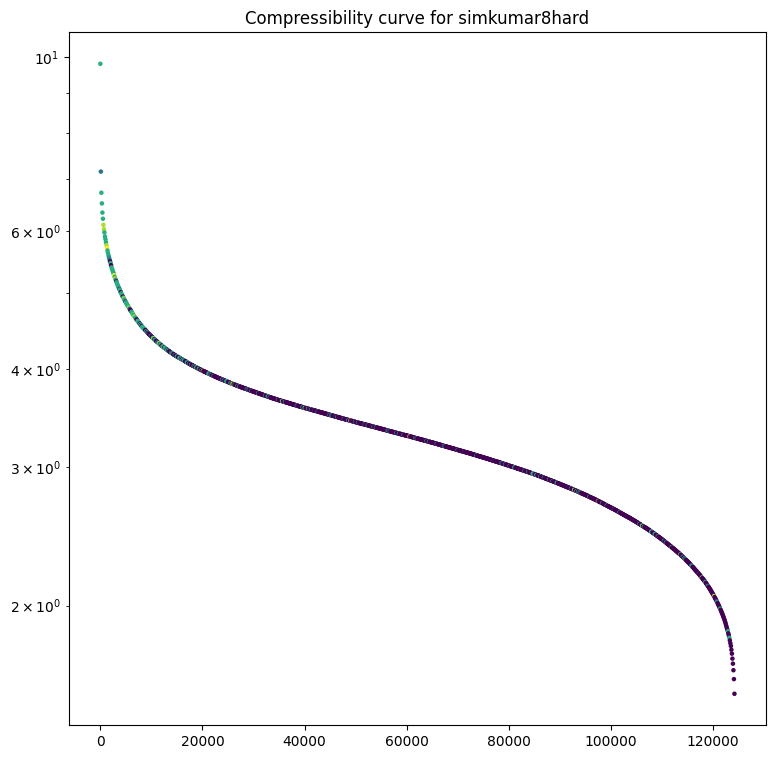

100%|██████████| 25/25 [03:09<00:00,  7.56s/it]


ARI without removal: 0.2183086524903493
NMI without removal: 0.34663888944352916
Avg intercluster compressibility [2.16728136 2.28913155 2.29475811]
Avg intracluster compressibility [2.68319283 2.46604441 2.60918672]


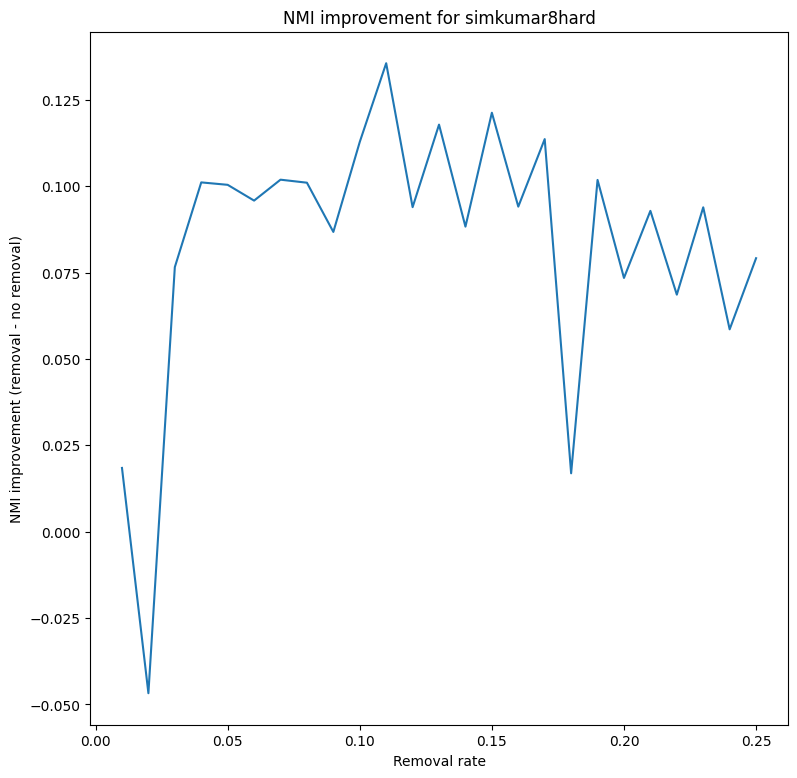

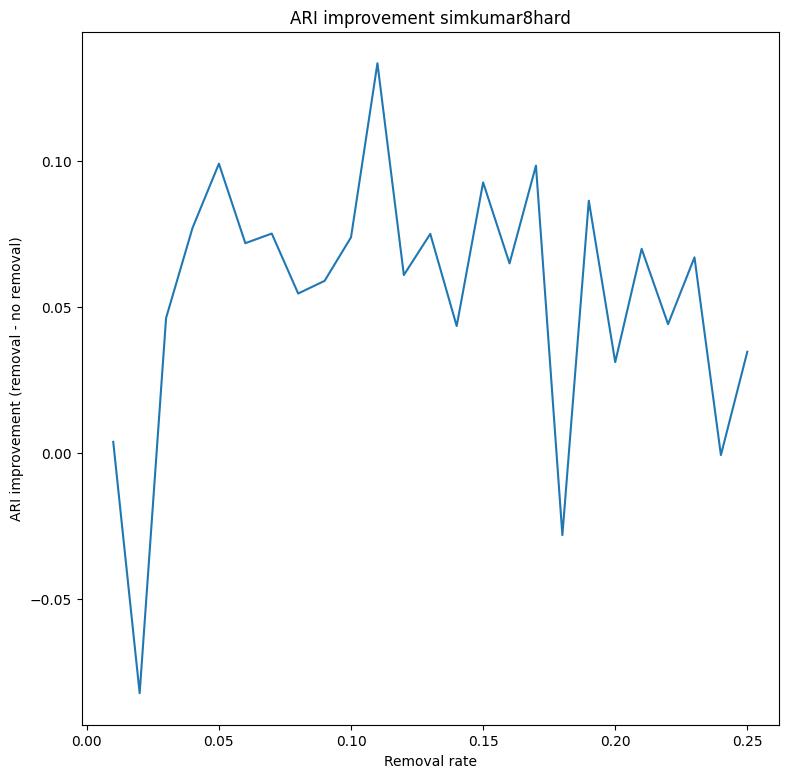

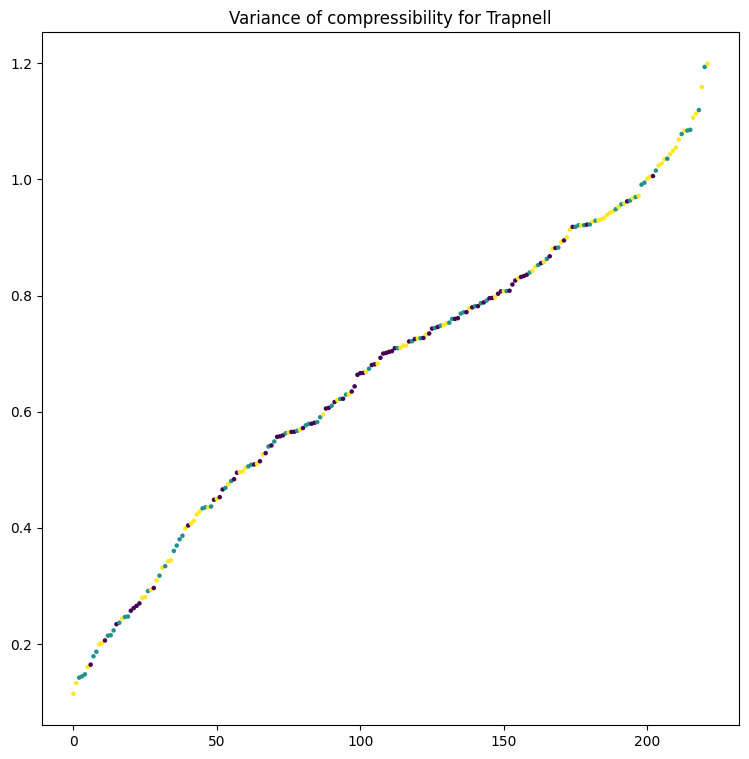

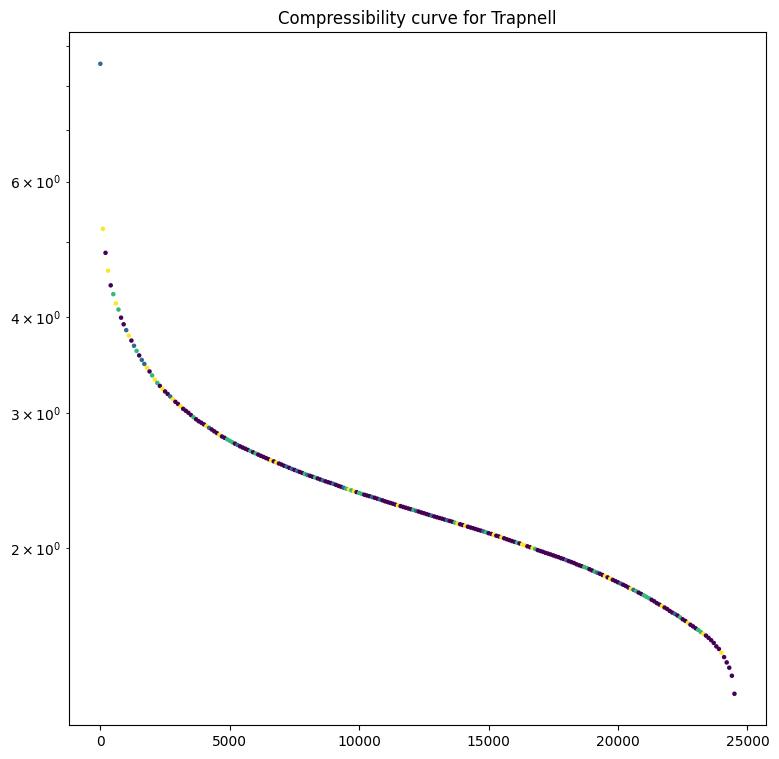

100%|██████████| 25/25 [01:09<00:00,  2.76s/it]


ARI without removal: 0.2518642489164145
NMI without removal: 0.2808563195142232
Avg intercluster compressibility [1.82284166 1.57686437 1.92191729 1.95916663]
Avg intracluster compressibility [2.87011168 2.83305542 3.28715046 2.83424695]


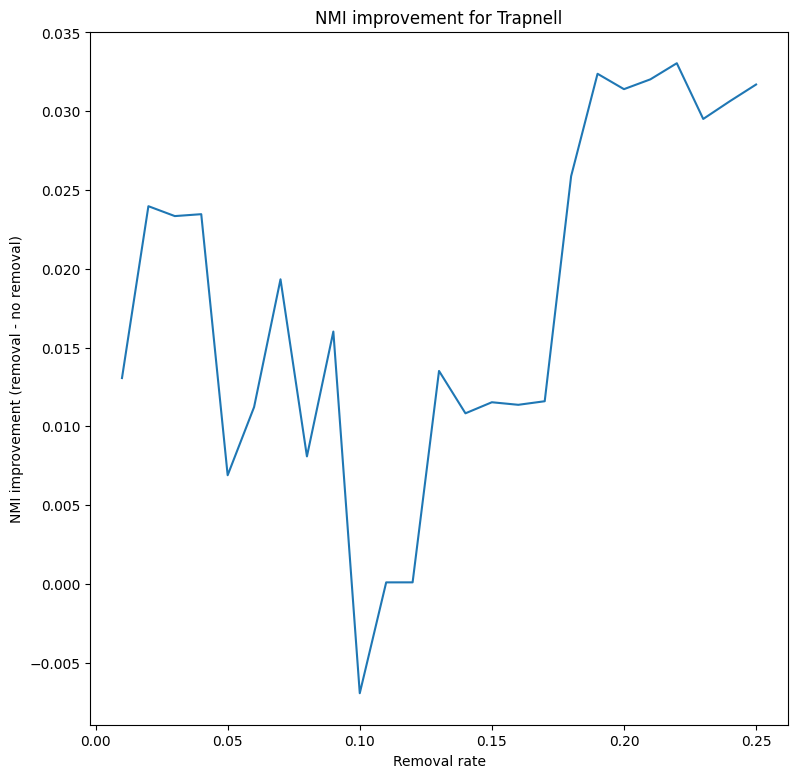

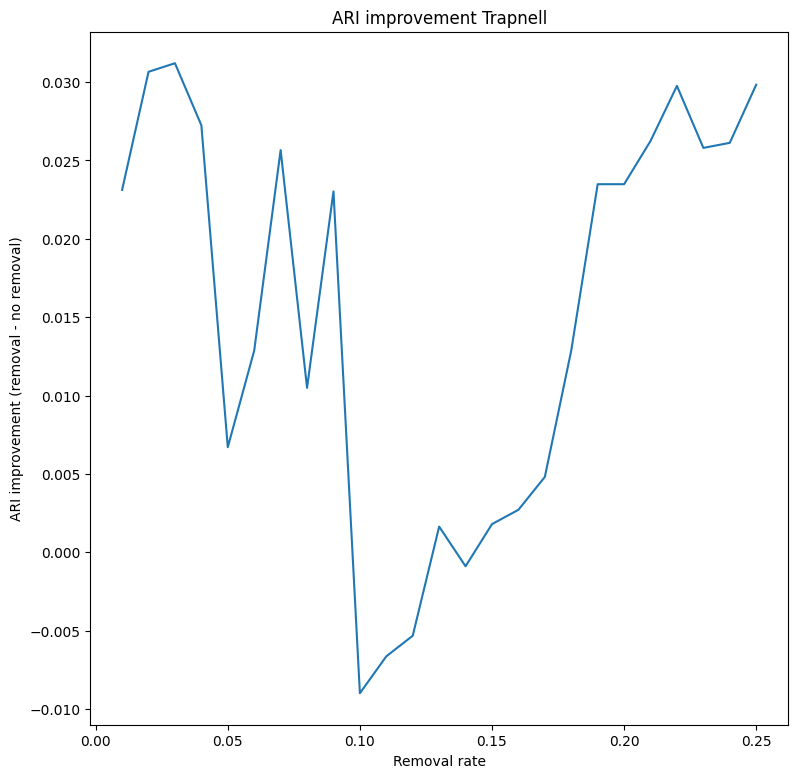

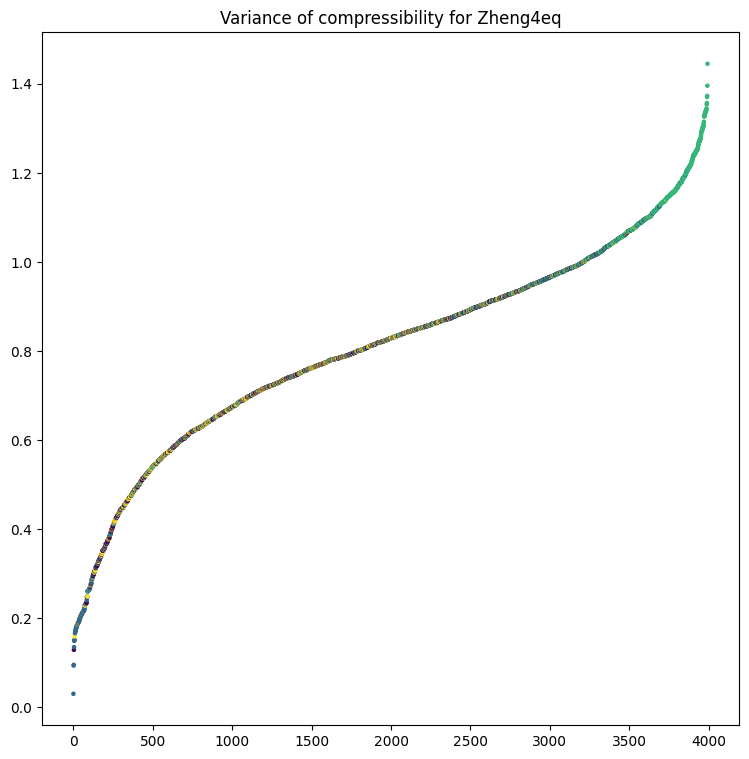

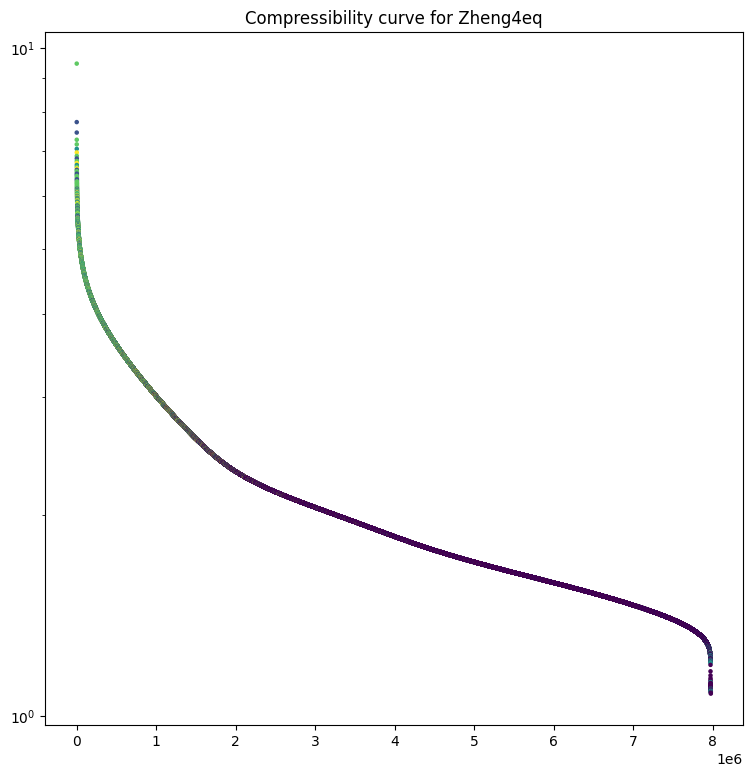

100%|██████████| 25/25 [05:12<00:00, 12.50s/it]


ARI without removal: 0.6305884379690194
NMI without removal: 0.710066669692735
Avg intercluster compressibility [1.74829851 1.58204448 1.9189966  1.76848069]
Avg intracluster compressibility [2.80671156 2.82133661 3.22319994 2.69537072]


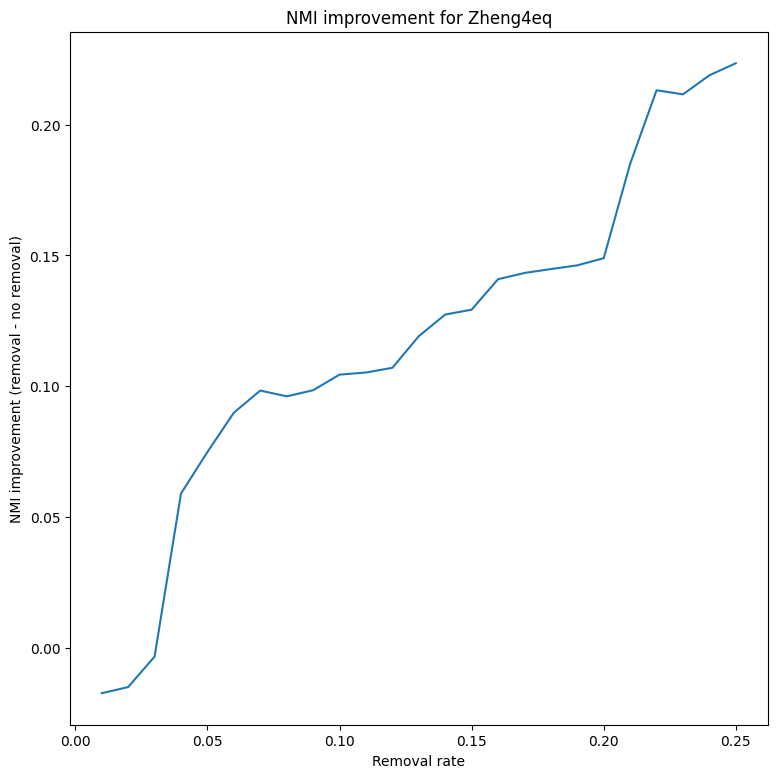

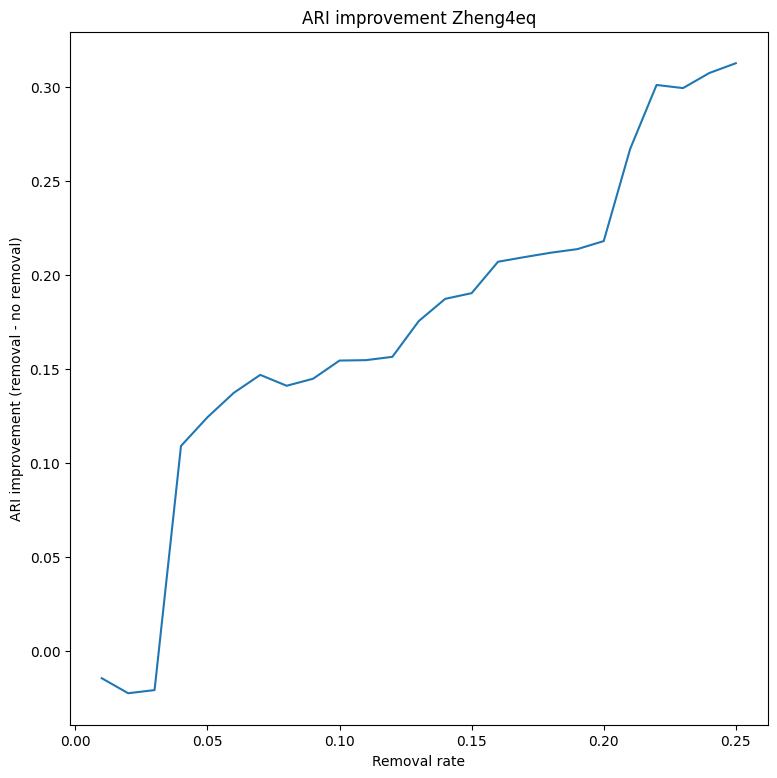

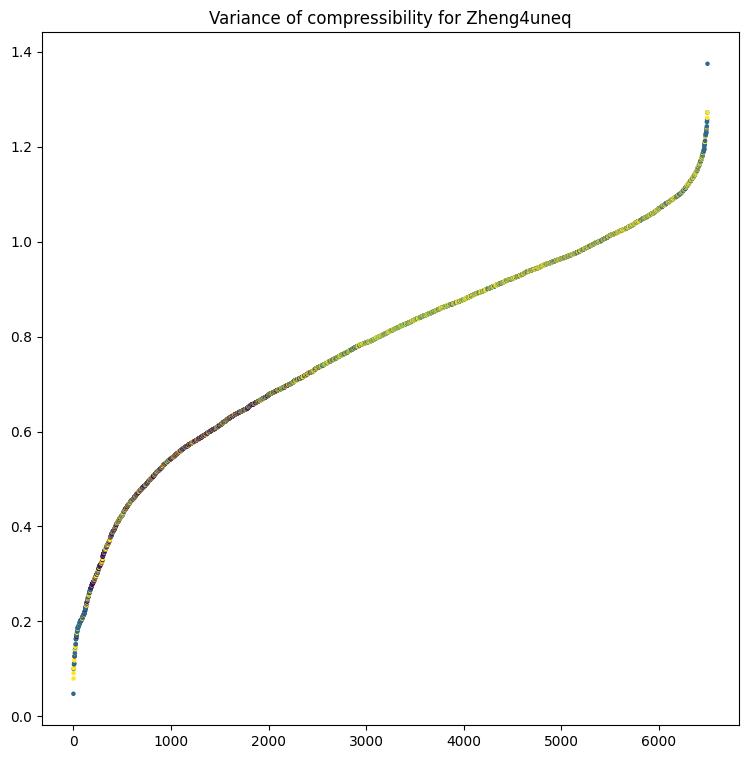

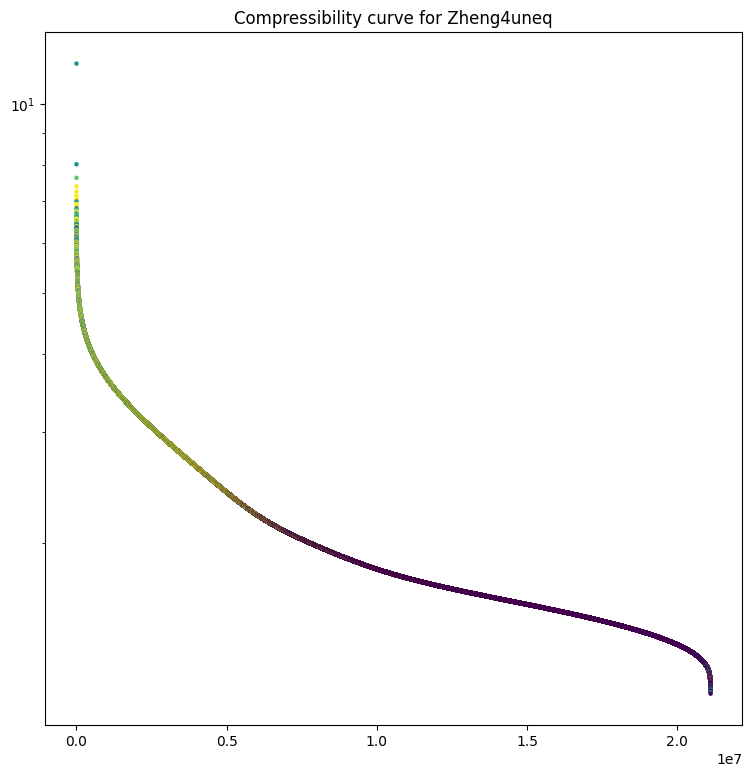

100%|██████████| 25/25 [09:58<00:00, 23.93s/it]


ARI without removal: 0.7397366722502212
NMI without removal: 0.7208462896478922
Avg intercluster compressibility [1.82831222 2.26792354 1.57258956 1.81089936 2.13962964 2.1549878
 2.20701304 2.19699293]
Avg intracluster compressibility [2.8474252  2.9884901  2.91762959 3.28626935 2.85608771 3.32786435
 3.07812691 2.87014336]


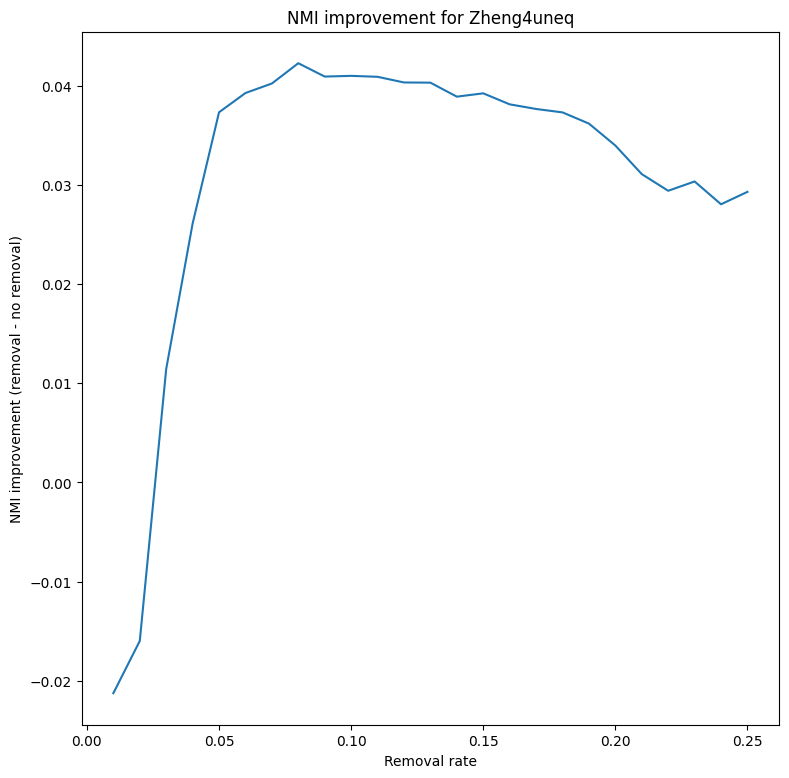

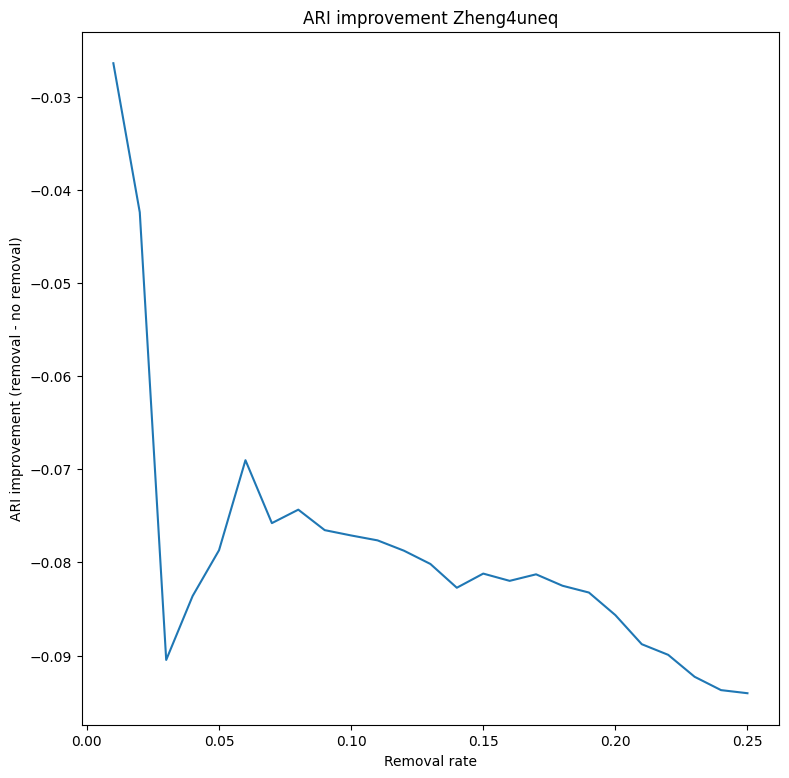

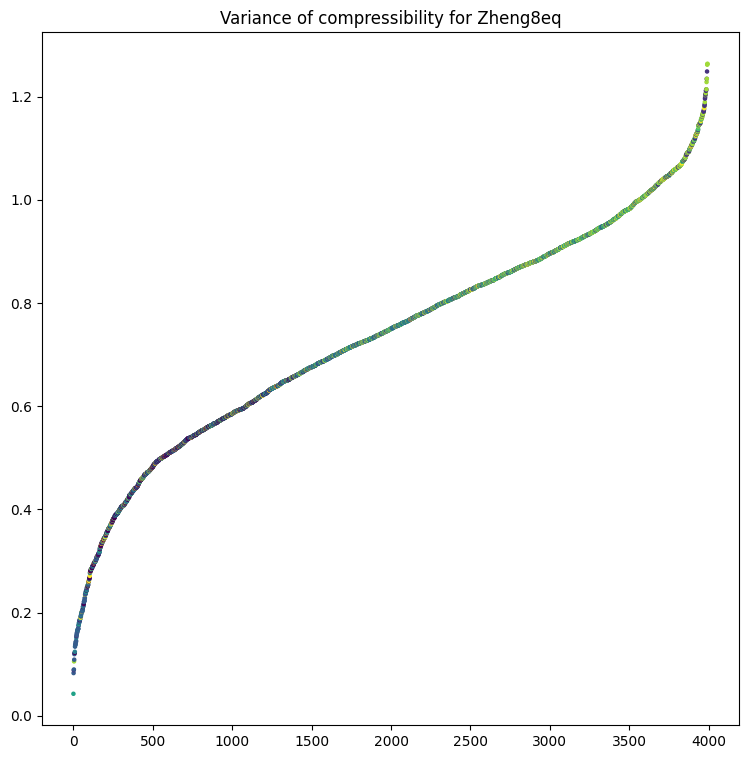

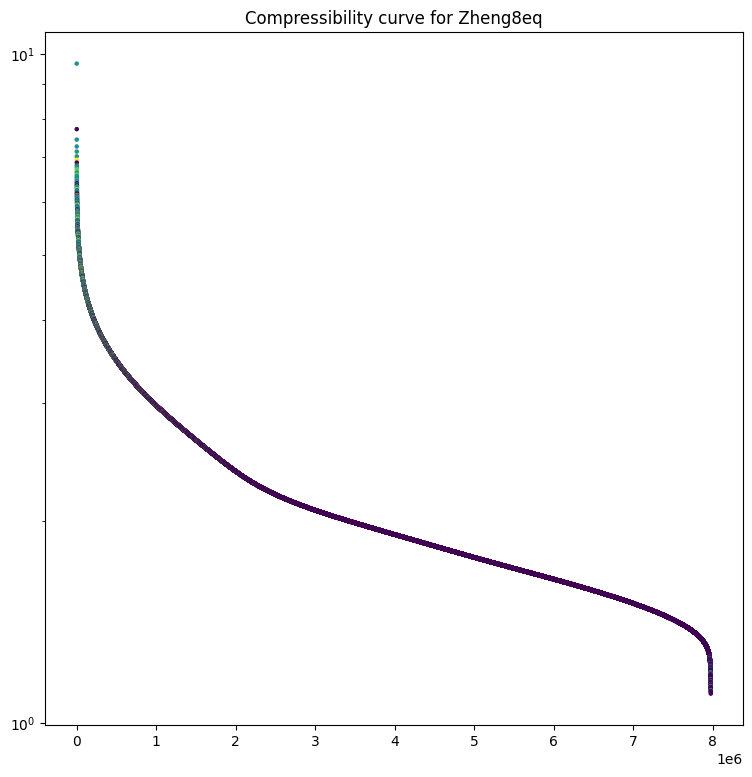

100%|██████████| 25/25 [05:52<00:00, 14.12s/it]


ARI without removal: 0.3952673360450466
NMI without removal: 0.5600928552958356


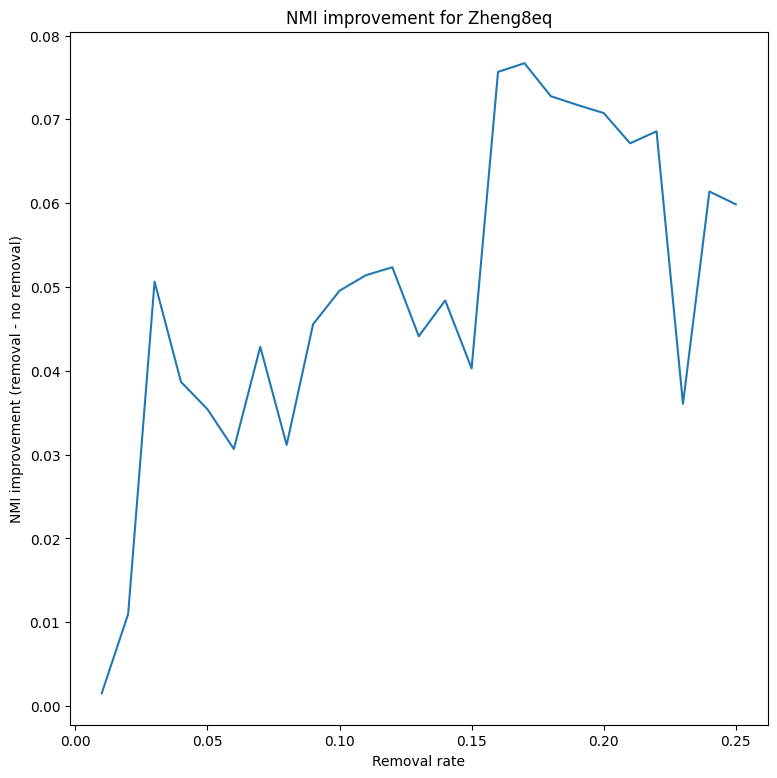

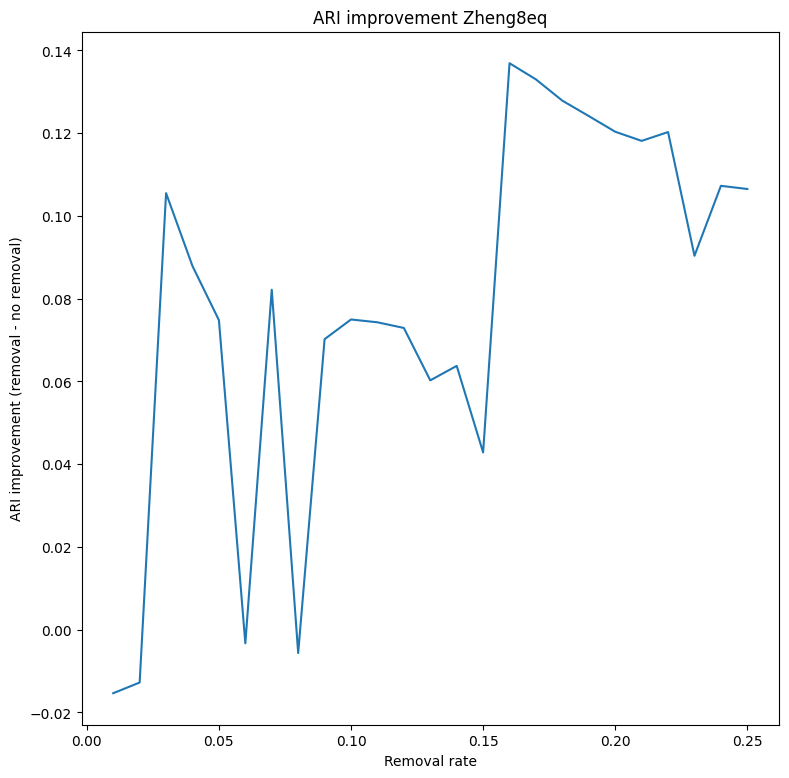

In [13]:
#EXP2
dimension=25
for fix_ch in range(9):
    data, cs, labels = initiate(fix_ch=fix_ch)
    C = np.load(dspath[fix_ch][:-5]+'_C_25.npy')
    process(data,cs,labels,dimension,fix_ch, C)